# Environment Setup

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FILEPATH = "/content/drive/MyDrive/ml/assignments/assignment4"

### Download Kaggle Dataset

In [ ]:
!pip install kaggle wandb onnx onnxruntime -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp "{FILEPATH}"/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 82% 235M/285M [00:00<00:00, 706MB/s] 
100% 285M/285M [00:00<00:00, 745MB/s]


In [ ]:
!mkdir /content/data

In [ ]:
!unzip -o challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d /content/data

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: /content/data/example_submission.csv  
  inflating: /content/data/fer2013.tar.gz  
  inflating: /content/data/icml_face_data.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


### Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from torchsummary import summary
import wandb

device = "cpu"
if torch.cuda.is_available():
  device = "cuda"

print("Using Device: ", device)

Using Device:  cuda


### Wabdb Login

In [ ]:
# 9f8f84f94f6c54c923b27fb88197f671df0e5aab
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vvaza22 (vvaza22-free-university-of-tbilisi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Setting Up Dataset

### Import training CSV file



In [ ]:
df = pd.read_csv("/content/data/train.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


### Make results predictable

In [ ]:
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

### Data Split Train/Validation/Test

In [ ]:
train = df.sample(frac=0.7, random_state=RANDOM_STATE)
test = df.drop(train.index)
val = test.sample(frac=0.5, random_state=RANDOM_STATE)
test = test.drop(val.index)

In [ ]:
train.shape, val.shape, test.shape

((20096, 2), (4306, 2), (4307, 2))

### Custom Image Dataset Class

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, imgset, dev, sub_mean=False, train_mean=None):
    self.imgset = imgset

    # Default device to store tensors
    self.dev = dev

    self.labels = self.get_labels()
    self.images = self.get_images()
    if train_mean is not None:
      # If mean image is provided use that
      self.mean_image = train_mean
    else:
      # If not calculate mean image of the current dataset
      self.mean_image = torch.mean(self.images, axis=0)

    if sub_mean:
      self.subtract_mean()

  def get_labels(self):
    tensor = torch.tensor(self.imgset['emotion'].values)
    return tensor.to(self.dev)

  def get_images(self):
    images = torch.zeros((len(self.imgset), 1, 48, 48), dtype=torch.float32)
    for i in range(len(self.imgset)):
      row = self.imgset.iloc[i]
      # Extract image from column
      pixels_str = row["pixels"]
      pixels = np.fromstring(pixels_str, sep=' ', dtype='float32').reshape(1, 48, 48)
      images[i] = torch.from_numpy(pixels)
    return images.to(self.dev)

  def subtract_mean(self):
    self.images = self.images - self.mean_image
    return self

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    # Extract image
    image = self.images[idx]

    # Extract label
    label = self.labels[idx]

    return image, label

### Visualize training data

In [ ]:
sample_images = train.sample(n=25, random_state=RANDOM_STATE)
sample_dataset = ImageDataset(imgset=sample_images, dev=device)

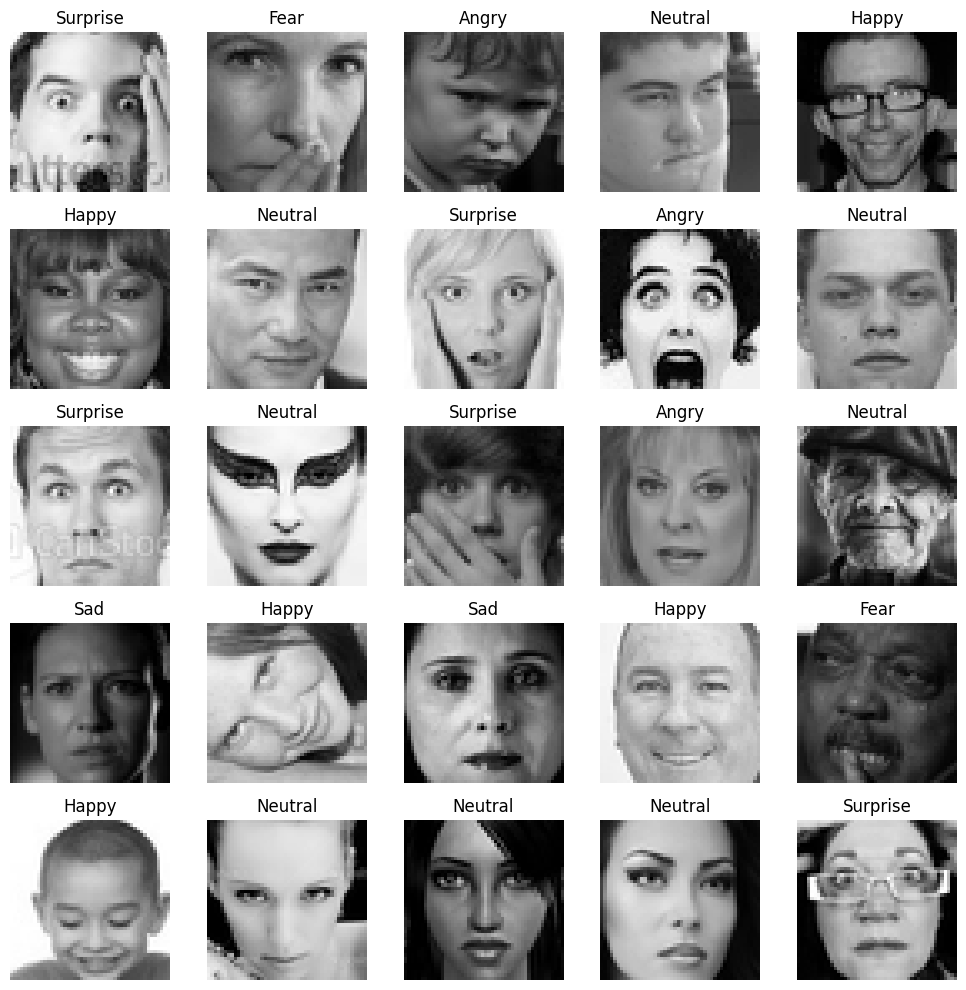

In [ ]:
emotion_dict = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    image, label = sample_dataset[i]
    ax.imshow(image.squeeze().cpu(), cmap='gray', vmin=0, vmax=255)
    ax.set_title(emotion_dict[label.item()])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Preprocessing

### Calculate Mean Image from Training Set

In [ ]:
sample_mean_dataset = ImageDataset(imgset=sample_images, dev=device, sub_mean=True)
sample_mean_dataset.mean_image.shape

torch.Size([1, 48, 48])

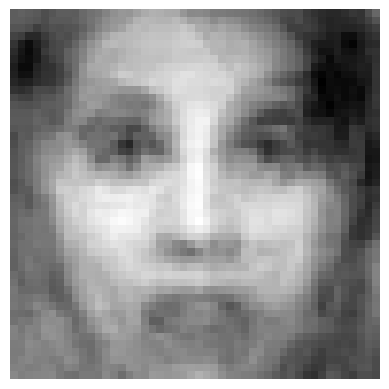

In [ ]:
# This is what mean image of the sample set looks like
img = sample_mean_dataset.mean_image.squeeze()
plt.imshow(img.cpu(), cmap='gray')
plt.axis('off')
plt.show()

### Visualize Preprocessed Images

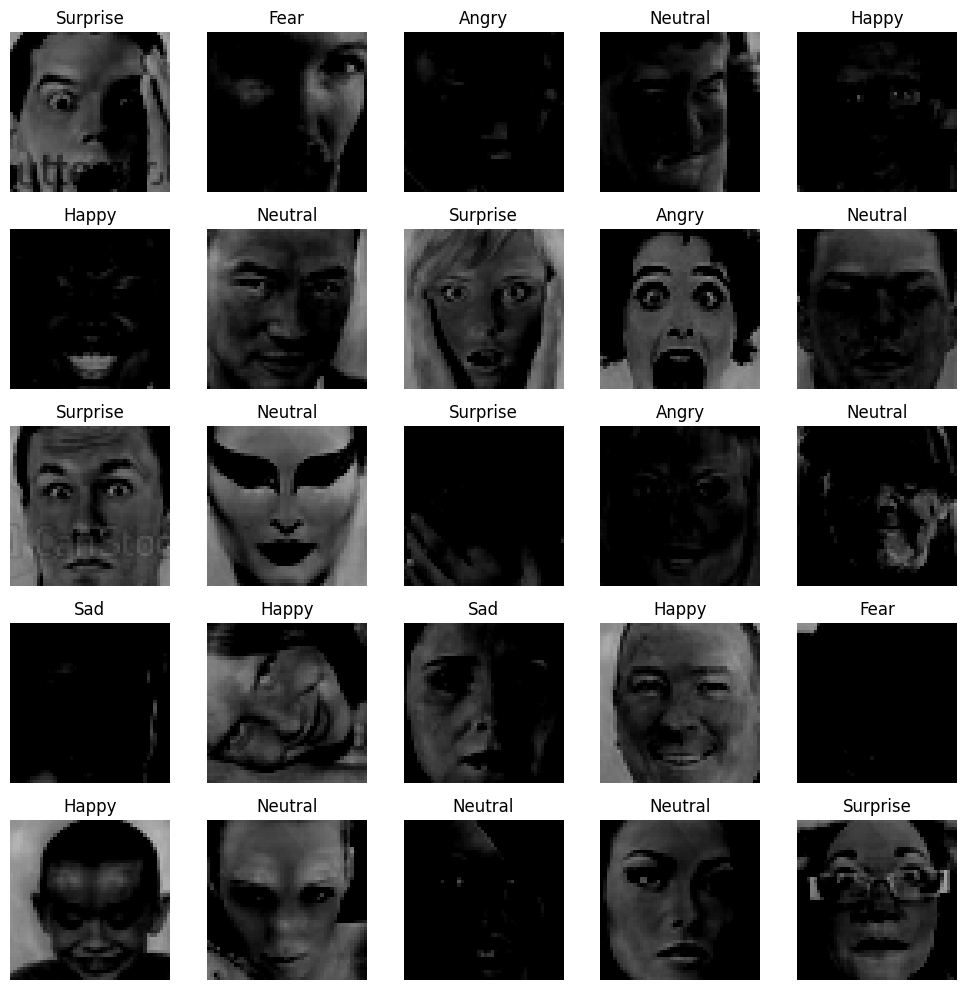

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    image, label = sample_mean_dataset[i]
    ax.imshow(image.squeeze().cpu(), cmap='gray', vmin=0, vmax=255)
    ax.set_title(emotion_dict[label.item()])
    ax.axis('off')

plt.tight_layout()
plt.show()

### Preprocess every dataset

In [ ]:
train_dataset = ImageDataset(imgset=train, dev=device, sub_mean=True)

# Avoid data leakage, subtract training set mean from validation set and test set
val_dataset = ImageDataset(imgset=val, dev=device, sub_mean=True, train_mean=train_dataset.mean_image)
test_dataset = ImageDataset(imgset=test, dev=device, sub_mean=True, train_mean=train_dataset.mean_image)

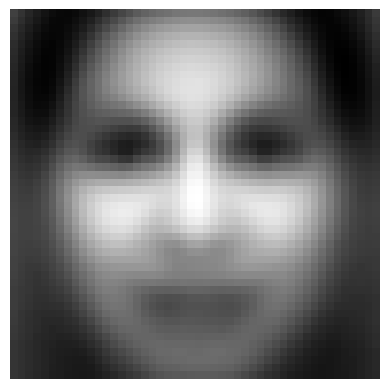

In [ ]:
# This is what mean image of the training set looks like
img = train_dataset.mean_image.squeeze()
plt.imshow(img.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Training

### Code for training models

In [ ]:
import time

ITER_PRINT_INTERVAL = 100

def train_model(model_data, loader, epochs=1, val_set_loader = None, logger=None):
  model = model_data.model
  optimizer = model_data.optimizer
  criterion = model_data.criterion
  batch_size = model_data.batch_size

  total_training_time = 0

  data_len = len(loader.dataset)
  val_data_len = 0
  if val_set_loader is not None:
    val_data_len = len(val_set_loader.dataset)

  for epoch in range(epochs):
    print(f"Epoch {epoch}")

    num_correct, total_loss, time_passed = train_model_for_one_epoch(model, optimizer, criterion, loader)
    train_avg_loss = total_loss / data_len
    train_accuracy = num_correct / data_len
    total_training_time += time_passed

    val_num_correct = 0
    validation_loss = -1
    validation_avg_loss = -1
    validation_accuracy = 0

    if val_set_loader is not None:
      val_num_correct, validation_loss = val_model(model, criterion, val_set_loader)
      validation_avg_loss = validation_loss / val_data_len
      validation_accuracy = val_num_correct / val_data_len

    print(f"Correct: {num_correct} / {data_len}, Train Accuracy: {train_accuracy}, Total Loss: {total_loss}, Avg Loss: {train_avg_loss}")
    if val_set_loader is not None:
      print(f"Validation: {val_num_correct} / {val_data_len}, Validation Accuracy: {validation_accuracy}, Total Loss: {total_loss}")
    print(f"Epoch training time: {time_passed} seconds")
    print("-------------------------------------------")
    print()

    if logger is not None:
      log_dict = {
          "epoch": epoch,
          "train_accuracy": train_accuracy,
          "train_loss": total_loss,
          "train_avg_loss": train_avg_loss,
          "epoch_training_time": time_passed,
          "total_training_time": total_training_time,
      }

      if val_set_loader is not None:
        log_dict["validation_accuracy"] = validation_accuracy
        log_dict["validation_loss"] = validation_loss
        log_dict["validation_avg_loss"] = validation_avg_loss

      logger(log_dict)

  print(f"Total training time: {total_training_time} seconds")


def train_model_for_one_epoch(model, optimizer, criterion, loader):
  # Keep track of statistics
  num_correct = 0
  total_loss = 0
  time_start = time.time()

  for iteration, (X, y) in enumerate(loader):
    # Activate model training mode
    model.train()

    # Forward pass
    scores = model(X)

    # Check number of correct answers
    model_answer = torch.argmax(scores, axis=1)
    num_correct += (model_answer == y).sum().item()

    # Get loss score
    loss = criterion(scores, y)
    total_loss += loss.item()

    # Zero the gradients
    optimizer.zero_grad()

    # Backwards pass
    loss.backward()

    # Update params of the model
    optimizer.step()

    if iteration % ITER_PRINT_INTERVAL == 0:
      print(f"Iteration {iteration}: Loss {loss.item()}")

  time_end = time.time()
  time_passed = time_end - time_start

  return num_correct, total_loss, time_passed


def val_model(model, criterion, loader):
  # Keep track of statistics
  num_correct = 0
  total_loss = 0

  with torch.no_grad():
    for iteration, (X, y) in enumerate(loader):
      # Activate model validation mode
      model.eval()

      # Forward pass
      scores = model(X)

      # Check number of correct answers
      model_answer = torch.argmax(scores, axis=1)
      num_correct += (model_answer == y).sum().item()

      # Get loss score
      loss = criterion(scores, y)
      total_loss += loss.item()

  return num_correct, total_loss

### Wandb Pipeline

In [ ]:
def training_logger(log_data):
  wandb.log(log_data)

def wandb_pipeline(model_data, train_set_loader, val_set_loader, epochs):
  run = wandb.init(
    project=model_data.project,
    name=model_data.model_name,
    config={
      "learning_rate": model_data.lr,
      "architecture": model_data.arch,
      "epochs": epochs,
      **model_data.params,
    },
  )

  wandb.watch(model_data.model, model_data.criterion, log="all", log_freq=10)

  train_model(model_data=model_data, loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs, logger=training_logger)

  sample_images, sample_labels = next(iter(train_set_loader))
  torch.onnx.export(model_data.model, sample_images, "model.onnx")
  wandb.save("model.onnx")

  run.finish()

### Code for sanity check

In [ ]:
def sanity_check(m, epochs=70):
  # Take random 25 images from the dataset and try to overfit on them
  # These are same images that are displayed above
  sanity_dataset = ImageDataset(imgset=sample_images, dev=device, sub_mean=True)
  m.train(sanity_dataset, epochs)

In [ ]:
def init_weights_and_biases(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    # Initialize weights
    init.kaiming_normal_(m.weight, nonlinearity='relu')

    # Initialize biases to 0
    init.zeros_(m.bias)

# Experiments

### Experiment 1: Linear-FCN-One-Layer

In [ ]:
class Model2:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "Linear-FCN-One-Layer"
    self.params = {}

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(model_input, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
sanity_model = Model2()
sanity_check(m=sanity_model, epochs=10)

Epoch 0
Iteration 0: Loss 107.23116302490234
Correct: 2 / 25, Train Accuracy: 0.08, Total Loss: 396.4394302368164, Avg Loss: 15.857577209472657
-------------------------------------------

Epoch 1
Iteration 0: Loss 90.74715423583984
Correct: 9 / 25, Train Accuracy: 0.36, Total Loss: 256.9413833618164, Avg Loss: 10.277655334472657
-------------------------------------------

Epoch 2
Iteration 0: Loss 41.24098587036133
Correct: 11 / 25, Train Accuracy: 0.44, Total Loss: 140.63380813598633, Avg Loss: 5.6253523254394535
-------------------------------------------

Epoch 3
Iteration 0: Loss 39.60912322998047
Correct: 15 / 25, Train Accuracy: 0.6, Total Loss: 99.29586791992188, Avg Loss: 3.971834716796875
-------------------------------------------

Epoch 4
Iteration 0: Loss 0.0
Correct: 22 / 25, Train Accuracy: 0.88, Total Loss: 21.851048469543457, Avg Loss: 0.8740419387817383
-------------------------------------------

Epoch 5
Iteration 0: Loss 8.03882122039795
Correct: 18 / 25, Train Acc

In [ ]:
m2 = Model2()
m2.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                    [-1, 7]          16,135
Total params: 16,135
Trainable params: 16,135
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.06
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


In [ ]:
m2.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 97.09737396240234
Iteration 100: Loss 92.55516052246094
Iteration 200: Loss 67.90983581542969
Iteration 300: Loss 40.69678497314453
Iteration 400: Loss 160.2957305908203
Iteration 500: Loss 131.75546264648438
Iteration 600: Loss 46.69004440307617
Iteration 700: Loss 58.768165588378906
Iteration 800: Loss 106.0898208618164
Iteration 900: Loss 52.21134567260742
Iteration 1000: Loss 76.358642578125
Iteration 1100: Loss 66.8156967163086
Iteration 1200: Loss 78.56385040283203
Iteration 1300: Loss 62.69898223876953
Iteration 1400: Loss 84.61832427978516
Iteration 1500: Loss 97.36210632324219
Iteration 1600: Loss 62.406494140625
Iteration 1700: Loss 77.78807067871094
Iteration 1800: Loss 63.35914993286133
Iteration 1900: Loss 107.84908294677734
Iteration 2000: Loss 64.7301025390625
Correct: 4758 / 20096, Train Accuracy: 0.23676353503184713, Total Loss: 172215.9716758728, Avg Loss: 8.569664195654498
Validation: 1063 / 4306, Validation Accuracy: 0.24686483975847653, To

epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_avg_loss,█▄▂▂▁
train_loss,█▄▂▂▁
validation_accuracy,▅▅▆█▁
validation_avg_loss,▄▇▂▁█
validation_loss,▄▇▂▁█
epoch,4
train_accuracy,0.27946
train_avg_loss,7.51398
train_loss,151001.0335


### Experiment 2: FCN-Two-Layer

In [ ]:
class Model1:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Two-Layer"
    self.params = {}

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
sanity_model = Model1()
sanity_check(m=sanity_model, epochs=10)

In [ ]:
m1 = Model1()
m1.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
              ReLU-3                 [-1, 4096]               0
            Linear-4                    [-1, 7]          28,679
Total params: 9,469,959
Trainable params: 9,469,959
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 36.13
Estimated Total Size (MB): 36.21
----------------------------------------------------------------


In [ ]:
m1.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 189.80027770996094
Iteration 100: Loss 188.5868682861328
Iteration 200: Loss 51.4427604675293
Iteration 300: Loss 70.85896301269531
Iteration 400: Loss 132.70223999023438
Iteration 500: Loss 85.61833190917969
Iteration 600: Loss 115.9870376586914
Iteration 700: Loss 119.59251403808594
Iteration 800: Loss 91.57847595214844
Iteration 900: Loss 98.82807922363281
Iteration 1000: Loss 87.49992370605469
Iteration 1100: Loss 78.06659698486328
Iteration 1200: Loss 92.46748352050781
Iteration 1300: Loss 91.97086334228516
Iteration 1400: Loss 84.89434814453125
Iteration 1500: Loss 118.08724212646484
Iteration 1600: Loss 87.54212951660156
Iteration 1700: Loss 58.54351806640625
Iteration 1800: Loss 96.14311218261719
Iteration 1900: Loss 42.30194091796875
Iteration 2000: Loss 68.12712097167969
Correct: 5457 / 20096, Train Accuracy: 0.271546576433121, Total Loss: 215643.02320289612, Avg Loss: 10.730644068615451
Validation: 1302 / 4306, Validation Accuracy: 0.302368787738039

epoch,▁▃▅▆█
train_accuracy,▁▄▅▆█
train_avg_loss,█▃▂▂▁
train_loss,█▃▂▂▁
validation_accuracy,▅▆▁█▇
validation_avg_loss,█▃█▁▁
validation_loss,█▃█▁▁
epoch,4
train_accuracy,0.42994
train_avg_loss,3.9563
train_loss,79505.84609


### Experiment 3: FCN-Three-Layer-SGD

In [ ]:
class Model3:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Three-Layer-SGD"
    self.params = {}

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
sanity_model = Model3()
sanity_check(m=sanity_model, epochs=10)

Epoch 0
Iteration 0: Loss 78.42385864257812
Correct: 2 / 25, Train Accuracy: 0.08, Total Loss: 756.8121948242188, Avg Loss: 30.27248779296875
Epoch training time: 0.012191295623779297 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 398.362060546875
Correct: 7 / 25, Train Accuracy: 0.28, Total Loss: 809.17431640625, Avg Loss: 32.36697265625
Epoch training time: 0.012662887573242188 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 261.92822265625
Correct: 17 / 25, Train Accuracy: 0.68, Total Loss: 281.63750648498535, Avg Loss: 11.265500259399413
Epoch training time: 0.012679338455200195 seconds
-------------------------------------------

Epoch 3
Iteration 0: Loss 0.0
Correct: 23 / 25, Train Accuracy: 0.92, Total Loss: 74.45767045021057, Avg Loss: 2.9783068180084227
Epoch training time: 0.01270914077758789 seconds
-------------------------------------------

Epoch 4
Iteration 0: Loss 26.815170288085938
Correct: 24 / 25, Train A

In [ ]:
m3 = Model3()
m3.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
              ReLU-5                 [-1, 4096]               0
            Linear-6                    [-1, 7]          28,679
Total params: 26,251,271
Trainable params: 26,251,271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 100.14
Estimated Total Size (MB): 100.29
----------------------------------------------------------------


In [ ]:
m3.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 190.91159057617188
Iteration 100: Loss 124.14637756347656
Iteration 200: Loss 23.79608726501465
Iteration 300: Loss 56.943580627441406
Iteration 400: Loss 37.45347213745117
Iteration 500: Loss 40.745018005371094
Iteration 600: Loss 21.33994483947754
Iteration 700: Loss 15.175165176391602
Iteration 800: Loss 18.207204818725586
Iteration 900: Loss 7.679980278015137
Iteration 1000: Loss 12.818199157714844
Iteration 1100: Loss 12.87725830078125
Iteration 1200: Loss 9.781366348266602
Iteration 1300: Loss 10.320555686950684
Iteration 1400: Loss 6.3188371658325195
Iteration 1500: Loss 10.130341529846191
Iteration 1600: Loss 10.729209899902344
Iteration 1700: Loss 9.259125709533691
Iteration 1800: Loss 5.657979488372803
Iteration 1900: Loss 5.118002891540527
Iteration 2000: Loss 7.758086204528809
Correct: 5726 / 20096, Train Accuracy: 0.2849323248407643, Total Loss: 59141.37812995911, Avg Loss: 2.9429427811484428
Validation: 1351 / 4306, Validation Accuracy: 0.3137482

epoch,▁▃▅▆█
epoch_training_time,█▄▃▄▁
total_training_time,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_avg_loss,█▂▁▁▁
train_loss,█▂▁▁▁
validation_accuracy,▁▅▇██
validation_avg_loss,█▂▁▁▂
validation_loss,█▂▁▁▂
epoch,4
epoch_training_time,187.94445


### Experiment 4: FCN-Three-Layer-Dropout

In [ ]:
class Model4:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Three-Layer-Dropout"
    self.params = {
        "dropout": 0.1
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
sanity_model = Model4()
sanity_check(m=sanity_model, epochs=10)

Epoch 0
Iteration 0: Loss 62.17570877075195
Correct: 6 / 25, Train Accuracy: 0.24, Total Loss: 725.2785987854004, Avg Loss: 29.011143951416017
-------------------------------------------

Epoch 1
Iteration 0: Loss 560.8167724609375
Correct: 10 / 25, Train Accuracy: 0.4, Total Loss: 963.6677612445783, Avg Loss: 38.546710449783134
-------------------------------------------

Epoch 2
Iteration 0: Loss 107.36064147949219
Correct: 15 / 25, Train Accuracy: 0.6, Total Loss: 312.35916900634766, Avg Loss: 12.494366760253905
-------------------------------------------

Epoch 3
Iteration 0: Loss 166.41610717773438
Correct: 15 / 25, Train Accuracy: 0.6, Total Loss: 326.7715644836426, Avg Loss: 13.070862579345704
-------------------------------------------

Epoch 4
Iteration 0: Loss 0.0
Correct: 20 / 25, Train Accuracy: 0.8, Total Loss: 55.46588706970215, Avg Loss: 2.218635482788086
-------------------------------------------

Epoch 5
Iteration 0: Loss 0.0
Correct: 22 / 25, Train Accuracy: 0.88, To

In [ ]:
m4 = Model4()
m4.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
              ReLU-3                 [-1, 4096]               0
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
              ReLU-6                 [-1, 4096]               0
           Dropout-7                 [-1, 4096]               0
            Linear-8                    [-1, 7]          28,679
Total params: 26,251,271
Trainable params: 26,251,271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 100.14
Estimated Total Size (MB): 100.35
----------------------------------------------------------------


In [ ]:
m4.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 137.6400604248047
Iteration 100: Loss 208.4250030517578
Iteration 200: Loss 55.978843688964844
Iteration 300: Loss 35.84149932861328
Iteration 400: Loss 79.62400817871094
Iteration 500: Loss 57.64813995361328
Iteration 600: Loss 16.723743438720703
Iteration 700: Loss 24.751537322998047
Iteration 800: Loss 25.036853790283203
Iteration 900: Loss 22.81540298461914
Iteration 1000: Loss 18.198135375976562
Iteration 1100: Loss 16.964073181152344
Iteration 1200: Loss 19.210359573364258
Iteration 1300: Loss 16.957992553710938
Iteration 1400: Loss 6.307112216949463
Iteration 1500: Loss 14.390417098999023
Iteration 1600: Loss 9.843944549560547
Iteration 1700: Loss 9.664270401000977
Iteration 1800: Loss 9.010591506958008
Iteration 1900: Loss 4.6837944984436035
Iteration 2000: Loss 4.61767053604126
Correct: 5490 / 20096, Train Accuracy: 0.2731886942675159, Total Loss: 70946.86551940441, Avg Loss: 3.5303973686009362
Validation: 1317 / 4306, Validation Accuracy: 0.305852299

epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_avg_loss,█▂▁▁▁
train_loss,█▂▁▁▁
validation_accuracy,▁▃▆▆█
validation_avg_loss,█▃▂▁▁
validation_loss,█▃▂▁▁
epoch,4
train_accuracy,0.55165
train_avg_loss,0.14269
train_loss,2867.59453


### Experiment 5: FCN-Three-Layer-Dropout-50

In [ ]:
class Model5:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Three-Layer-Dropout-50"
    self.params = {
        "dropout": 0.5
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
sanity_model = Model5()
sanity_check(m=sanity_model, epochs=10)

Epoch 0
Iteration 0: Loss 164.4554901123047
Correct: 3 / 25, Train Accuracy: 0.12, Total Loss: 1725.356185913086, Avg Loss: 69.01424743652343
-------------------------------------------

Epoch 1
Iteration 0: Loss 655.783203125
Correct: 6 / 25, Train Accuracy: 0.24, Total Loss: 1300.113265991211, Avg Loss: 52.004530639648436
-------------------------------------------

Epoch 2
Iteration 0: Loss 289.80401611328125
Correct: 10 / 25, Train Accuracy: 0.4, Total Loss: 571.8607482910156, Avg Loss: 22.874429931640623
-------------------------------------------

Epoch 3
Iteration 0: Loss 151.88400268554688
Correct: 15 / 25, Train Accuracy: 0.6, Total Loss: 222.88137817382812, Avg Loss: 8.915255126953125
-------------------------------------------

Epoch 4
Iteration 0: Loss 50.205867767333984
Correct: 13 / 25, Train Accuracy: 0.52, Total Loss: 646.8527488708496, Avg Loss: 25.874109954833983
-------------------------------------------

Epoch 5
Iteration 0: Loss 6.4289140701293945
Correct: 18 / 25

In [ ]:
m5 = Model5()
m5.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
              ReLU-3                 [-1, 4096]               0
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
              ReLU-6                 [-1, 4096]               0
           Dropout-7                 [-1, 4096]               0
            Linear-8                    [-1, 7]          28,679
Total params: 26,251,271
Trainable params: 26,251,271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 100.14
Estimated Total Size (MB): 100.35
----------------------------------------------------------------


In [ ]:
m5.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 259.84722900390625
Iteration 100: Loss 271.0299377441406
Iteration 200: Loss 382.9424743652344
Iteration 300: Loss 179.29916381835938
Iteration 400: Loss 139.1298370361328
Iteration 500: Loss 98.2717056274414
Iteration 600: Loss 67.17362213134766
Iteration 700: Loss 90.92784118652344
Iteration 800: Loss 135.8766632080078
Iteration 900: Loss 61.926780700683594
Iteration 1000: Loss 64.81330871582031
Iteration 1100: Loss 62.98802947998047
Iteration 1200: Loss 32.78010559082031
Iteration 1300: Loss 36.62047576904297
Iteration 1400: Loss 27.12948989868164
Iteration 1500: Loss 22.501953125
Iteration 1600: Loss 24.66031837463379
Iteration 1700: Loss 35.45880889892578
Iteration 1800: Loss 20.982017517089844
Iteration 1900: Loss 22.748462677001953
Iteration 2000: Loss 24.251876831054688
Correct: 4696 / 20096, Train Accuracy: 0.23367834394904458, Total Loss: 187278.66285276413, Avg Loss: 9.319200977944075
Validation: 992 / 4306, Validation Accuracy: 0.23037621922898283,

epoch,▁▃▅▆█
train_accuracy,▅█▅▄▁
train_avg_loss,█▂▁▁▁
train_loss,█▂▁▁▁
validation_accuracy,▂▁▃▇█
validation_avg_loss,█▁▁▁▁
validation_loss,█▁▁▁▁
epoch,4
train_accuracy,0.22328
train_avg_loss,0.28355
train_loss,5698.21001


### Experiment 6: FCN-Four-Layer-Dropout-50

In [ ]:
class Model6:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Four-Layer-Dropout-50"
    self.params = {
        "dropout": 0.5
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
sanity_model = Model6()
sanity_check(m=sanity_model, epochs=50)

Epoch 0
Iteration 0: Loss 284.477294921875
Correct: 6 / 25, Train Accuracy: 0.24, Total Loss: 1991.6825561523438, Avg Loss: 79.66730224609375
-------------------------------------------

Epoch 1
Iteration 0: Loss 689.9315185546875
Correct: 5 / 25, Train Accuracy: 0.2, Total Loss: 2265.7786865234375, Avg Loss: 90.6311474609375
-------------------------------------------

Epoch 2
Iteration 0: Loss 1228.1005859375
Correct: 6 / 25, Train Accuracy: 0.24, Total Loss: 3655.6511840820312, Avg Loss: 146.22604736328125
-------------------------------------------

Epoch 3
Iteration 0: Loss 1231.042236328125
Correct: 6 / 25, Train Accuracy: 0.24, Total Loss: 2280.6483154296875, Avg Loss: 91.2259326171875
-------------------------------------------

Epoch 4
Iteration 0: Loss 562.1046752929688
Correct: 4 / 25, Train Accuracy: 0.16, Total Loss: 2592.1861572265625, Avg Loss: 103.6874462890625
-------------------------------------------

Epoch 5
Iteration 0: Loss 534.9290771484375
Correct: 12 / 25, Tra

In [ ]:
m6 = Model6()
m6.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
              ReLU-3                 [-1, 4096]               0
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
              ReLU-6                 [-1, 4096]               0
           Dropout-7                 [-1, 4096]               0
            Linear-8                 [-1, 4096]      16,781,312
              ReLU-9                 [-1, 4096]               0
          Dropout-10                 [-1, 4096]               0
           Linear-11                    [-1, 7]          28,679
Total params: 43,032,583
Trainable params: 43,032,583
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

In [ ]:
m6.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 161.2981414794922
Iteration 100: Loss 467.34796142578125
Iteration 200: Loss 180.61184692382812
Iteration 300: Loss 172.41563415527344
Iteration 400: Loss 113.75936126708984
Iteration 500: Loss 112.1281967163086
Iteration 600: Loss 63.79499435424805
Iteration 700: Loss 41.047142028808594
Iteration 800: Loss 71.8985595703125
Iteration 900: Loss 73.59822845458984
Iteration 1000: Loss 51.14930725097656
Iteration 1100: Loss 16.868694305419922
Iteration 1200: Loss 37.513206481933594
Iteration 1300: Loss 10.06074047088623
Iteration 1400: Loss 18.5176944732666
Iteration 1500: Loss 16.082685470581055
Iteration 1600: Loss 5.337116241455078
Iteration 1700: Loss 8.919618606567383
Iteration 1800: Loss 8.999115943908691
Iteration 1900: Loss 5.297222137451172
Iteration 2000: Loss 7.503619194030762
Correct: 4083 / 20096, Train Accuracy: 0.20317476114649682, Total Loss: 169880.66257667542, Avg Loss: 8.453456537453992
Validation: 1102 / 4306, Validation Accuracy: 0.25592196934

epoch,▁▃▅▆█
train_accuracy,▇▁▃▆█
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,▁▁▁▁▁
validation_avg_loss,█▇▅▃▁
validation_loss,█▇▅▃▁
epoch,4
train_accuracy,0.20905
train_avg_loss,0.21307
train_loss,4281.91057


### Experiment 7: FCN-Five-Layer-Dropout-50

In [ ]:
class Model7:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Five-Layer-Dropout-50"
    self.params = {
        "dropout": 0.5
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
m7 = Model7()
m7.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
              ReLU-3                 [-1, 4096]               0
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
              ReLU-6                 [-1, 4096]               0
           Dropout-7                 [-1, 4096]               0
            Linear-8                 [-1, 4096]      16,781,312
              ReLU-9                 [-1, 4096]               0
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 4096]      16,781,312
             ReLU-12                 [-1, 4096]               0
          Dropout-13                 [-1, 4096]               0
           Linear-14                   

In [ ]:
m7.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 513.6162109375
Iteration 100: Loss 311.942138671875
Iteration 200: Loss 299.79205322265625
Iteration 300: Loss 143.75778198242188
Iteration 400: Loss 160.9762725830078
Iteration 500: Loss 53.589332580566406
Iteration 600: Loss 41.473854064941406
Iteration 700: Loss 51.7471809387207
Iteration 800: Loss 48.276344299316406
Iteration 900: Loss 25.577884674072266
Iteration 1000: Loss 28.329822540283203
Iteration 1100: Loss 20.234817504882812
Iteration 1200: Loss 17.27393913269043
Iteration 1300: Loss 20.090293884277344
Iteration 1400: Loss 16.240154266357422
Iteration 1500: Loss 12.861735343933105
Iteration 1600: Loss 11.077543258666992
Iteration 1700: Loss 11.064209938049316
Iteration 1800: Loss 7.3114213943481445
Iteration 1900: Loss 5.575445652008057
Iteration 2000: Loss 6.171896934509277
Correct: 3691 / 20096, Train Accuracy: 0.18366839171974522, Total Loss: 166279.00705623627, Avg Loss: 8.274234029470355
Validation: 1104 / 4306, Validation Accuracy: 0.25638643

epoch,▁▃▅▆█
train_accuracy,▃▁▄▆█
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,█▁▁▁▁
validation_avg_loss,█▇▅▃▁
validation_loss,█▇▅▃▁
epoch,4
train_accuracy,0.2076
train_avg_loss,0.2132
train_loss,4284.55871


### Experiment 8: FCN-Three-Layer-Momentum

In [ ]:
class Model8:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Three-Layer-Momentum"
    self.params = {
        "momentum": 0.9,
    }

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.params["momentum"])

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
m8 = Model8()
m8.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
              ReLU-5                 [-1, 4096]               0
            Linear-6                    [-1, 7]          28,679
Total params: 26,251,271
Trainable params: 26,251,271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 100.14
Estimated Total Size (MB): 100.29
----------------------------------------------------------------


In [ ]:
m8.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 138.4886016845703
Iteration 100: Loss 22.793060302734375
Iteration 200: Loss 5.128504276275635
Iteration 300: Loss 4.538830757141113
Iteration 400: Loss 2.646967649459839
Iteration 500: Loss 2.3538150787353516
Iteration 600: Loss 1.8528039455413818
Iteration 700: Loss 2.061609983444214
Iteration 800: Loss 1.7640587091445923
Iteration 900: Loss 2.3292007446289062
Iteration 1000: Loss 2.1462135314941406
Iteration 1100: Loss 1.6685596704483032
Iteration 1200: Loss 2.1574299335479736
Iteration 1300: Loss 2.4392402172088623
Iteration 1400: Loss 3.265014171600342
Iteration 1500: Loss 1.9880183935165405
Iteration 1600: Loss 1.572967529296875
Iteration 1700: Loss 1.894404649734497
Iteration 1800: Loss 1.8770596981048584
Iteration 1900: Loss 1.896223783493042
Iteration 2000: Loss 1.8401062488555908
Correct: 4709 / 20096, Train Accuracy: 0.23432523885350318, Total Loss: 20076.36017227173, Avg Loss: 0.9990226996552413
Validation: 1140 / 4306, Validation Accuracy: 0.26474

epoch,▁▃▅▆█
epoch_training_time,█▅▅▁▆
total_training_time,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,▁▄▇▇█
validation_avg_loss,▂▄▁▆█
validation_loss,▂▄▁▆█
epoch,4
epoch_training_time,190.60048


### Experiment 9: FCN-Three-Layer-Momentum-Nesterov

In [ ]:
class Model9:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Three-Layer-Momentum-Nesterov"
    self.params = {
        "momentum": 0.9,
    }

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.params["momentum"], nesterov=True)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
m9 = Model9()
m9.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
              ReLU-5                 [-1, 4096]               0
            Linear-6                    [-1, 7]          28,679
Total params: 26,251,271
Trainable params: 26,251,271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 100.14
Estimated Total Size (MB): 100.29
----------------------------------------------------------------


In [ ]:
m9.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 110.02811431884766
Iteration 100: Loss 12.990676879882812
Iteration 200: Loss 2.8703272342681885
Iteration 300: Loss 2.835357189178467
Iteration 400: Loss 2.887476921081543
Iteration 500: Loss 2.160372018814087
Iteration 600: Loss 1.597867727279663
Iteration 700: Loss 2.1582555770874023
Iteration 800: Loss 1.9539129734039307
Iteration 900: Loss 1.5622813701629639
Iteration 1000: Loss 1.7884076833724976
Iteration 1100: Loss 1.783565878868103
Iteration 1200: Loss 2.6307878494262695
Iteration 1300: Loss 1.798266053199768
Iteration 1400: Loss 2.045372486114502
Iteration 1500: Loss 2.4108097553253174
Iteration 1600: Loss 1.798606514930725
Iteration 1700: Loss 1.8063774108886719
Iteration 1800: Loss 1.807206392288208
Iteration 1900: Loss 2.5160629749298096
Iteration 2000: Loss 1.8346713781356812
Correct: 4911 / 20096, Train Accuracy: 0.24437699044585987, Total Loss: 18242.856038093567, Avg Loss: 0.9077854318318853
Validation: 1136 / 4306, Validation Accuracy: 0.2638

epoch,▁▃▅▆█
epoch_training_time,▄▄▁▃█
total_training_time,▁▃▄▆█
train_accuracy,▁▄▅▇█
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,▁▄▆▆█
validation_avg_loss,▁▁▁▅█
validation_loss,▁▁▁▅█
epoch,4
epoch_training_time,204.34281


### Experiment 10: FCN-Three-Layer-RMSprop

In [ ]:
class Model10:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Three-Layer-RMSprop"
    self.params = {
        "alpha": 0.99,
    }

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.RMSprop(self.model.parameters(), lr=self.lr, alpha=self.params["alpha"])

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
m10 = Model10()
m10.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
              ReLU-5                 [-1, 4096]               0
            Linear-6                    [-1, 7]          28,679
Total params: 26,251,271
Trainable params: 26,251,271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 100.14
Estimated Total Size (MB): 100.29
----------------------------------------------------------------


In [ ]:
m10.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 142.87374877929688
Iteration 100: Loss 54.953399658203125
Iteration 200: Loss 44.00360107421875
Iteration 300: Loss 15.085311889648438
Iteration 400: Loss 30.357507705688477
Iteration 500: Loss 21.107011795043945
Iteration 600: Loss 6.718571662902832
Iteration 700: Loss 9.656694412231445
Iteration 800: Loss 5.183350086212158
Iteration 900: Loss 3.613548994064331
Iteration 1000: Loss 1.7947181463241577
Iteration 1100: Loss 3.486403226852417
Iteration 1200: Loss 4.268813133239746
Iteration 1300: Loss 1.7107658386230469
Iteration 1400: Loss 3.660982608795166
Iteration 1500: Loss 1.7679933309555054
Iteration 1600: Loss 2.7051777839660645
Iteration 1700: Loss 2.2069857120513916
Iteration 1800: Loss 1.824546217918396
Iteration 1900: Loss 1.9222300052642822
Iteration 2000: Loss 2.0363948345184326
Correct: 4918 / 20096, Train Accuracy: 0.24472531847133758, Total Loss: 40764.5665358305, Avg Loss: 2.0284915672686354
Validation: 1160 / 4306, Validation Accuracy: 0.269391

epoch,▁▃▅▆█
epoch_training_time,▁▁▇█▇
total_training_time,▁▃▄▆█
train_accuracy,▁▄▆▇█
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,▁▆▆██
validation_avg_loss,█▁█▃▁
validation_loss,█▁█▃▁
epoch,4
epoch_training_time,197.40232


### Experiment 11: FCN-Three-Layer-Adam

In [ ]:
class Model11:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Three-Layer-Adam"
    self.params = {}

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
m11 = Model11()
m11.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
              ReLU-5                 [-1, 4096]               0
            Linear-6                    [-1, 7]          28,679
Total params: 26,251,271
Trainable params: 26,251,271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 100.14
Estimated Total Size (MB): 100.29
----------------------------------------------------------------


In [ ]:
m11.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 109.24305725097656
Iteration 100: Loss 60.865272521972656
Iteration 200: Loss 93.72998046875
Iteration 300: Loss 82.0658187866211
Iteration 400: Loss 59.10347366333008
Iteration 500: Loss 24.300228118896484
Iteration 600: Loss 14.696742057800293
Iteration 700: Loss 9.144490242004395
Iteration 800: Loss 10.583186149597168
Iteration 900: Loss 8.98393726348877
Iteration 1000: Loss 9.54106616973877
Iteration 1100: Loss 4.282168865203857
Iteration 1200: Loss 3.2995858192443848
Iteration 1300: Loss 4.150425910949707
Iteration 1400: Loss 2.394954204559326
Iteration 1500: Loss 2.254251003265381
Iteration 1600: Loss 2.1530251502990723
Iteration 1700: Loss 2.5056653022766113
Iteration 1800: Loss 1.259487271308899
Iteration 1900: Loss 2.5742554664611816
Iteration 2000: Loss 2.0471208095550537
Correct: 5440 / 20096, Train Accuracy: 0.27070063694267515, Total Loss: 52967.001838982105, Avg Loss: 2.635698738006673
Validation: 1266 / 4306, Validation Accuracy: 0.2940083604273

epoch,▁▃▅▆█
epoch_training_time,█▇▇▁▇
total_training_time,▁▃▅▆█
train_accuracy,▁████
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,▁▅▄▆█
validation_avg_loss,▆█▆▃▁
validation_loss,▆█▆▃▁
epoch,4
epoch_training_time,172.69184


### Experiment 12: FCN-Three-Layer-BatchNorm

In [ ]:
class Model12:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Three-Layer-BatchNorm"
    self.params = {
        "optimizer": "adam"
    }

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
sanity_model = Model12()
sanity_check(m=sanity_model, epochs=50)

Epoch 0
Iteration 0: Loss 2.2885489463806152
Correct: 2 / 25, Train Accuracy: 0.08, Total Loss: 8.206222295761108, Avg Loss: 0.3282488918304443
Epoch training time: 0.5968499183654785 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 0.6380041837692261
Correct: 19 / 25, Train Accuracy: 0.76, Total Loss: 2.9837249368429184, Avg Loss: 0.11934899747371673
Epoch training time: 0.03757143020629883 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 0.21854658424854279
Correct: 23 / 25, Train Accuracy: 0.92, Total Loss: 0.7051716446876526, Avg Loss: 0.028206865787506103
Epoch training time: 0.03295755386352539 seconds
-------------------------------------------

Epoch 3
Iteration 0: Loss 0.05125742405653
Correct: 25 / 25, Train Accuracy: 1.0, Total Loss: 0.16109083406627178, Avg Loss: 0.006443633362650871
Epoch training time: 0.03338360786437988 seconds
-------------------------------------------

Epoch 4
Iteration 0: Loss 0.03669382259

In [ ]:
m12 = Model12()
m12.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
       BatchNorm1d-6                 [-1, 4096]           8,192
              ReLU-7                 [-1, 4096]               0
            Linear-8                    [-1, 7]          28,679
Total params: 26,267,655
Trainable params: 26,267,655
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 100.20
Estimated Total Size (MB): 100.42
----------------------------------------------------------------


In [ ]:
m12.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 2.601228713989258
Iteration 100: Loss 2.5804734230041504
Iteration 200: Loss 2.1871209144592285
Iteration 300: Loss 2.2185170650482178
Iteration 400: Loss 2.2206404209136963
Iteration 500: Loss 2.404236316680908
Iteration 600: Loss 2.1530237197875977
Iteration 700: Loss 1.7999610900878906
Iteration 800: Loss 2.541572332382202
Iteration 900: Loss 1.4772899150848389
Iteration 1000: Loss 2.1619529724121094
Iteration 1100: Loss 1.6493499279022217
Iteration 1200: Loss 1.5149562358856201
Iteration 1300: Loss 1.751858115196228
Iteration 1400: Loss 2.1254899501800537
Iteration 1500: Loss 1.98325514793396
Iteration 1600: Loss 2.2582688331604004
Iteration 1700: Loss 1.8791933059692383
Iteration 1800: Loss 1.9303680658340454
Iteration 1900: Loss 1.8134574890136719
Iteration 2000: Loss 2.117457866668701
Correct: 5854 / 20096, Train Accuracy: 0.29130175159235666, Total Loss: 3887.898843765259, Avg Loss: 0.1934663039294018
Validation: 1286 / 4306, Validation Accuracy: 0.298

epoch,▁▃▅▆█
epoch_training_time,▁▄▃▅█
total_training_time,▁▃▄▆█
train_accuracy,▁▄▅▇█
train_avg_loss,█▄▃▂▁
train_loss,█▄▃▂▁
validation_accuracy,▁▆▅▇█
validation_avg_loss,█▂▃▂▁
validation_loss,█▂▃▂▁
epoch,4
epoch_training_time,182.998


### Experiment 13: FCN-Three-Layer-BatchNorm-BatchSize-100

In [ ]:
class Model13:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 100

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCNN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Three-Layer-BatchNorm-BatchSize-100"
    self.params = {
        "optimizer": "adam"
    }

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
m13 = Model13()
m13.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
       BatchNorm1d-6                 [-1, 4096]           8,192
              ReLU-7                 [-1, 4096]               0
            Linear-8                    [-1, 7]          28,679
Total params: 26,267,655
Trainable params: 26,267,655
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 100.20
Estimated Total Size (MB): 100.42
----------------------------------------------------------------


In [ ]:
m13.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 2.3499577045440674
Iteration 100: Loss 1.760143756866455
Iteration 200: Loss 1.7592558860778809
Correct: 6868 / 20096, Train Accuracy: 0.3417595541401274, Total Loss: 364.9462226629257, Avg Loss: 0.018160142449389217
Validation: 1585 / 4306, Validation Accuracy: 0.36809103576405017, Total Loss: 364.9462226629257
Epoch training time: 18.751421689987183 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 1.4119393825531006
Iteration 100: Loss 1.3043917417526245
Iteration 200: Loss 1.5977903604507446
Correct: 10196 / 20096, Train Accuracy: 0.5073646496815286, Total Loss: 268.9262298345566, Avg Loss: 0.013382077519633587
Validation: 1647 / 4306, Validation Accuracy: 0.3824895494658616, Total Loss: 268.9262298345566
Epoch training time: 18.974876165390015 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.1695550680160522
Iteration 100: Loss 1.0726561546325684
Iteration 200: Loss 1.2008637189865112
Correct: 1

epoch,▁▃▅▆█
epoch_training_time,▂▃▆▁█
total_training_time,▁▃▄▆█
train_accuracy,▁▄▅▇█
train_avg_loss,█▅▃▂▁
train_loss,█▅▃▂▁
validation_accuracy,▁▃▄▆█
validation_avg_loss,▁▇▄▄█
validation_loss,▁▇▄▄█
epoch,4
epoch_training_time,20.00678


### Experiment 14: FCN-Three-Layer-BatchNorm-BatchSize-200

In [ ]:
class Model14:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCNN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Three-Layer-BatchNorm-BatchSize-200"
    self.params = {
        "optimizer": "adam"
    }

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
m14 = Model14()
m14.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
       BatchNorm1d-6                 [-1, 4096]           8,192
              ReLU-7                 [-1, 4096]               0
            Linear-8                    [-1, 7]          28,679
Total params: 26,267,655
Trainable params: 26,267,655
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 100.20
Estimated Total Size (MB): 100.42
----------------------------------------------------------------


In [ ]:
m14.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 2.16792368888855
Iteration 100: Loss 1.7725080251693726
Correct: 6898 / 20096, Train Accuracy: 0.34325238853503187, Total Loss: 179.98584175109863, Avg Loss: 0.008956301838729032
Validation: 1605 / 4306, Validation Accuracy: 0.3727357176033442, Total Loss: 179.98584175109863
Epoch training time: 9.545917510986328 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 1.1663068532943726
Iteration 100: Loss 1.3517013788223267
Correct: 10577 / 20096, Train Accuracy: 0.5263236464968153, Total Loss: 130.25602114200592, Avg Loss: 0.006481688950139626
Validation: 1676 / 4306, Validation Accuracy: 0.3892243381328379, Total Loss: 130.25602114200592
Epoch training time: 9.690078973770142 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.0137207508087158
Iteration 100: Loss 0.9308827519416809
Correct: 12719 / 20096, Train Accuracy: 0.6329120222929936, Total Loss: 105.48522698879242, Avg Loss: 0.0052490658334391135
Va

epoch,▁▃▅▆█
epoch_training_time,▇█▁▃▇
total_training_time,▁▃▄▆█
train_accuracy,▁▄▅▇█
train_avg_loss,█▅▃▂▁
train_loss,█▅▃▂▁
validation_accuracy,▁▃▆▇█
validation_avg_loss,█▁▁▆▂
validation_loss,█▁▁▆▂
epoch,4
epoch_training_time,9.50507


### Experiment 15: FCN-Five-Layer-BatchNorm

In [ ]:
class Model15:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.arch = "FCNN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Five-Layer-BatchNorm"
    self.params = {
        "optimizer": "adam"
    }

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
m15 = Model15()
m15.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
       BatchNorm1d-6                 [-1, 4096]           8,192
              ReLU-7                 [-1, 4096]               0
            Linear-8                 [-1, 4096]      16,781,312
       BatchNorm1d-9                 [-1, 4096]           8,192
             ReLU-10                 [-1, 4096]               0
           Linear-11                 [-1, 4096]      16,781,312
      BatchNorm1d-12                 [-1, 4096]           8,192
             ReLU-13                 [-1, 4096]               0
           Linear-14                   

In [ ]:
m15.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 2.178443670272827
Iteration 100: Loss 1.6696895360946655
Correct: 6883 / 20096, Train Accuracy: 0.3425059713375796, Total Loss: 184.7375738620758, Avg Loss: 0.009192753476416989
Validation: 1501 / 4306, Validation Accuracy: 0.34858337203901535, Total Loss: 184.7375738620758
Epoch training time: 20.96247625350952 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 0.9969505071640015
Iteration 100: Loss 1.1204192638397217
Correct: 12771 / 20096, Train Accuracy: 0.635499601910828, Total Loss: 104.44485682249069, Avg Loss: 0.005197295821182857
Validation: 1738 / 4306, Validation Accuracy: 0.4036228518346493, Total Loss: 104.44485682249069
Epoch training time: 21.52485179901123 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 0.5758602023124695
Iteration 100: Loss 0.7395698428153992
Correct: 16144 / 20096, Train Accuracy: 0.803343949044586, Total Loss: 63.802656412124634, Avg Loss: 0.003174893332609705
Valida

epoch,▁▃▅▆█
epoch_training_time,▃▄▅█▁
total_training_time,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_avg_loss,█▅▃▂▁
train_loss,█▅▃▂▁
validation_accuracy,▁▆▆█▇
validation_avg_loss,▃▁▆▅█
validation_loss,▃▁▆▅█
epoch,4
epoch_training_time,20.23212


### Experiment 16: FCN-Five-Layer-BatchNorm-Dropout-50

In [ ]:
class Model16:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "FCNN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Five-Layer-BatchNorm-Dropout-50"
    self.params = {
        "optimizer": "adam",
        "dropout": 0.5
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
m16 = Model16()
m16.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
           Dropout-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
       BatchNorm1d-7                 [-1, 4096]           8,192
              ReLU-8                 [-1, 4096]               0
           Dropout-9                 [-1, 4096]               0
           Linear-10                 [-1, 4096]      16,781,312
      BatchNorm1d-11                 [-1, 4096]           8,192
             ReLU-12                 [-1, 4096]               0
          Dropout-13                 [-1, 4096]               0
           Linear-14                 [-

In [ ]:
m16.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 2.6916842460632324
Iteration 100: Loss 2.026254415512085
Correct: 4480 / 20096, Train Accuracy: 0.2229299363057325, Total Loss: 230.03214645385742, Avg Loss: 0.011446663338667269
Validation: 1492 / 4306, Validation Accuracy: 0.346493265211333, Total Loss: 230.03214645385742
Epoch training time: 21.35368299484253 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 2.0296177864074707
Iteration 100: Loss 2.2601990699768066
Correct: 5281 / 20096, Train Accuracy: 0.2627886146496815, Total Loss: 216.32774484157562, Avg Loss: 0.010764716602387321
Validation: 1535 / 4306, Validation Accuracy: 0.35647933116581515, Total Loss: 216.32774484157562
Epoch training time: 20.393236875534058 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 2.101466417312622
Iteration 100: Loss 1.9300140142440796
Correct: 5575 / 20096, Train Accuracy: 0.27741839171974525, Total Loss: 209.91390347480774, Avg Loss: 0.010445556502528252
Vali

epoch,▁▃▅▆█
epoch_training_time,▃▁▂█▅
total_training_time,▁▃▄▆█
train_accuracy,▁▅▆██
train_avg_loss,█▅▃▂▁
train_loss,█▅▃▂▁
validation_accuracy,▁▄▆▆█
validation_avg_loss,█▁▃▆▇
validation_loss,█▁▃▆▇
epoch,4
epoch_training_time,22.53701


### Experiment 17: FCN-Five-Layer-BatchNorm-Dropout-30

In [ ]:
class Model17:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "FCNN"

    self.project = "Assignment4-FullyConnectedNetwork"
    self.model_name = "FCN-Five-Layer-BatchNorm-Dropout-30"
    self.params = {
        "optimizer": "adam",
        "dropout": 0.3
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Flatten(),

      nn.Linear(model_input, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
m17 = Model17()
m17.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 4096]       9,441,280
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
           Dropout-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
       BatchNorm1d-7                 [-1, 4096]           8,192
              ReLU-8                 [-1, 4096]               0
           Dropout-9                 [-1, 4096]               0
           Linear-10                 [-1, 4096]      16,781,312
      BatchNorm1d-11                 [-1, 4096]           8,192
             ReLU-12                 [-1, 4096]               0
          Dropout-13                 [-1, 4096]               0
           Linear-14                 [-

In [ ]:
m17.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 2.5164167881011963
Iteration 100: Loss 1.9209908246994019
Correct: 5494 / 20096, Train Accuracy: 0.2733877388535032, Total Loss: 205.10379588603973, Avg Loss: 0.010206200034138123
Validation: 1522 / 4306, Validation Accuracy: 0.353460287970274, Total Loss: 205.10379588603973
Epoch training time: 21.878122568130493 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 1.8069878816604614
Iteration 100: Loss 1.6859692335128784
Correct: 6556 / 20096, Train Accuracy: 0.326234076433121, Total Loss: 188.67502546310425, Avg Loss: 0.009388685582359885
Validation: 1618 / 4306, Validation Accuracy: 0.37575476079888526, Total Loss: 188.67502546310425
Epoch training time: 20.174848318099976 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.5635628700256348
Iteration 100: Loss 1.7974222898483276
Correct: 7088 / 20096, Train Accuracy: 0.35270700636942676, Total Loss: 179.22843480110168, Avg Loss: 0.008918612400532528
Va

epoch,▁▃▅▆█
epoch_training_time,▅▁▇█▁
total_training_time,▁▃▄▆█
train_accuracy,▁▄▆▇█
train_avg_loss,█▅▃▂▁
train_loss,█▅▃▂▁
validation_accuracy,▁▄▅▄█
validation_avg_loss,█▃▃▃▁
validation_loss,█▃▃▃▁
epoch,4
epoch_training_time,20.31795


## Convulutional Neural Networks

### Experiment 1: 1-Layer-CNN-1-Layer-FCNN

In [ ]:
class ModelCNN1:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "1-Layer-CNN-1-Layer-FCNN"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),

      nn.Flatten(),

      nn.Linear(model_input * 32, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
sanity_model = ModelCNN1()
sanity_check(m=sanity_model, epochs=50)

Epoch 0
Iteration 0: Loss 106.71339416503906
Correct: 3 / 25, Train Accuracy: 0.12, Total Loss: 623.3958892822266, Avg Loss: 24.93583557128906
Epoch training time: 0.8426601886749268 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 143.77267456054688
Correct: 6 / 25, Train Accuracy: 0.24, Total Loss: 404.7567253112793, Avg Loss: 16.19026901245117
Epoch training time: 0.025451183319091797 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 109.58943939208984
Correct: 16 / 25, Train Accuracy: 0.64, Total Loss: 145.63074493408203, Avg Loss: 5.825229797363281
Epoch training time: 0.013564348220825195 seconds
-------------------------------------------

Epoch 3
Iteration 0: Loss 20.802459716796875
Correct: 20 / 25, Train Accuracy: 0.8, Total Loss: 59.314918518066406, Avg Loss: 2.3725967407226562
Epoch training time: 0.006806373596191406 seconds
-------------------------------------------

Epoch 4
Iteration 0: Loss 6.482717990875244
Co

In [ ]:
mcnn1 = ModelCNN1()
mcnn1.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
           Flatten-3                [-1, 73728]               0
            Linear-4                    [-1, 7]         516,103
Total params: 516,423
Trainable params: 516,423
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.69
Params size (MB): 1.97
Estimated Total Size (MB): 3.67
----------------------------------------------------------------


In [ ]:
mcnn1.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 171.7324676513672
Iteration 100: Loss 161.75660705566406
Iteration 200: Loss 230.537353515625
Iteration 300: Loss 130.93727111816406
Iteration 400: Loss 199.1020050048828
Iteration 500: Loss 148.3761749267578
Iteration 600: Loss 120.6519775390625
Iteration 700: Loss 107.36579895019531
Iteration 800: Loss 181.72764587402344
Iteration 900: Loss 103.276123046875
Iteration 1000: Loss 97.27576446533203
Iteration 1100: Loss 49.45717239379883
Iteration 1200: Loss 91.11593627929688
Iteration 1300: Loss 105.0477294921875
Iteration 1400: Loss 57.833221435546875
Iteration 1500: Loss 80.26303100585938
Iteration 1600: Loss 64.34474182128906
Iteration 1700: Loss 88.81978607177734
Iteration 1800: Loss 76.10270690917969
Iteration 1900: Loss 77.39913177490234
Iteration 2000: Loss 77.0640640258789
Correct: 5534 / 20096, Train Accuracy: 0.2753781847133758, Total Loss: 207004.746489048, Avg Loss: 10.300793515577627
Validation: 1424 / 4306, Validation Accuracy: 0.3307013469577334,

epoch,▁▃▅▆█
epoch_training_time,▆▁█▁▄
total_training_time,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_avg_loss,█▃▂▁▁
train_loss,█▃▂▁▁
validation_accuracy,▁▇█▆▇
validation_avg_loss,█▃▂▂▁
validation_loss,█▃▂▂▁
epoch,4
epoch_training_time,7.54452


### Experiment 2: 1-Layer-CNN-64-Channels-1-Layer-FCNN

In [ ]:
class ModelCNN2:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "1-Layer-CNN-64-Channels-1-Layer-FCNN"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),

      nn.Flatten(),

      nn.Linear(model_input * 64, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn2 = ModelCNN2()
mcnn2.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
              ReLU-2           [-1, 64, 48, 48]               0
           Flatten-3               [-1, 147456]               0
            Linear-4                    [-1, 7]       1,032,199
Total params: 1,032,839
Trainable params: 1,032,839
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 3.38
Params size (MB): 3.94
Estimated Total Size (MB): 7.32
----------------------------------------------------------------


In [ ]:
mcnn2.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 95.04178619384766
Iteration 100: Loss 413.02667236328125
Iteration 200: Loss 218.88119506835938
Iteration 300: Loss 90.0696792602539
Iteration 400: Loss 204.90283203125
Iteration 500: Loss 62.19838333129883
Iteration 600: Loss 80.37178802490234
Iteration 700: Loss 147.3382110595703
Iteration 800: Loss 275.90289306640625
Iteration 900: Loss 210.9311981201172
Iteration 1000: Loss 313.90521240234375
Iteration 1100: Loss 315.3979187011719
Iteration 1200: Loss 292.15948486328125
Iteration 1300: Loss 91.80575561523438
Iteration 1400: Loss 166.4872589111328
Iteration 1500: Loss 228.2797088623047
Iteration 1600: Loss 88.64836883544922
Iteration 1700: Loss 123.76129150390625
Iteration 1800: Loss 96.39070129394531
Iteration 1900: Loss 161.7572479248047
Iteration 2000: Loss 97.6891098022461
Correct: 5694 / 20096, Train Accuracy: 0.2833399681528662, Total Loss: 406403.81928157806, Avg Loss: 20.223119988135853
Validation: 1497 / 4306, Validation Accuracy: 0.347654435671156

epoch,▁▃▅▆█
epoch_training_time,▁▁█▅▂
total_training_time,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_avg_loss,█▃▂▁▁
train_loss,█▃▂▁▁
validation_accuracy,▁▂█▅█
validation_avg_loss,█▃▂▂▁
validation_loss,█▃▂▂▁
epoch,4
epoch_training_time,9.30516


### Experiment 3: 2-Layer-CNN-1-Layer-FCNN

In [ ]:
class ModelCNN3:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "2-Layer-CNN-1-Layer-FCNN"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),

      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),

      nn.Flatten(),

      nn.Linear(model_input * 32, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn3 = ModelCNN3()
mcnn3.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
              ReLU-2           [-1, 64, 48, 48]               0
            Conv2d-3           [-1, 32, 48, 48]          18,464
              ReLU-4           [-1, 32, 48, 48]               0
           Flatten-5                [-1, 73728]               0
            Linear-6                    [-1, 7]         516,103
Total params: 535,207
Trainable params: 535,207
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 3.94
Params size (MB): 2.04
Estimated Total Size (MB): 5.99
----------------------------------------------------------------


In [ ]:
mcnn3.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 64.45777130126953
Iteration 100: Loss 24.960647583007812
Iteration 200: Loss 9.552839279174805
Iteration 300: Loss 4.316508769989014
Iteration 400: Loss 4.618001461029053
Iteration 500: Loss 4.064772605895996
Iteration 600: Loss 3.643557071685791
Iteration 700: Loss 2.4777939319610596
Iteration 800: Loss 2.3347229957580566
Iteration 900: Loss 2.0345816612243652
Iteration 1000: Loss 2.4165892601013184
Iteration 1100: Loss 2.271333694458008
Iteration 1200: Loss 2.140920639038086
Iteration 1300: Loss 2.276887893676758
Iteration 1400: Loss 1.905395269393921
Iteration 1500: Loss 2.0224080085754395
Iteration 1600: Loss 1.9151254892349243
Iteration 1700: Loss 1.803459882736206
Iteration 1800: Loss 1.9470046758651733
Iteration 1900: Loss 1.781001091003418
Iteration 2000: Loss 1.6099903583526611
Correct: 4769 / 20096, Train Accuracy: 0.2373109076433121, Total Loss: 13109.096697092056, Avg Loss: 0.6523236811849152
Validation: 1080 / 4306, Validation Accuracy: 0.25081281

epoch,▁▃▅▆█
epoch_training_time,▄█▁▆█
total_training_time,▁▃▄▆█
train_accuracy,▁▂▄▇█
train_avg_loss,█▃▂▁▁
train_loss,█▃▂▁▁
validation_accuracy,▁▅███
validation_avg_loss,▁▁▂▄█
validation_loss,▁▁▂▄█
epoch,4
epoch_training_time,8.87607


### Experiment 4: 2-Layer-CNN-1-Layer-FCNN-MaxPool

In [ ]:
class ModelCNN4:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "2-Layer-CNN-1-Layer-FCNN-MaxPool"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(4608, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn4 = ModelCNN4()
mcnn4.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
              ReLU-2           [-1, 64, 48, 48]               0
         MaxPool2d-3           [-1, 64, 24, 24]               0
            Conv2d-4           [-1, 32, 24, 24]          18,464
              ReLU-5           [-1, 32, 24, 24]               0
         MaxPool2d-6           [-1, 32, 12, 12]               0
           Flatten-7                 [-1, 4608]               0
            Linear-8                    [-1, 7]          32,263
Total params: 51,367
Trainable params: 51,367
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.88
Params size (MB): 0.20
Estimated Total Size (MB): 3.09
----------------------------------------------------------------


In [ ]:
mcnn4.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 66.89266204833984
Iteration 100: Loss 41.57902526855469
Iteration 200: Loss 46.163002014160156
Iteration 300: Loss 22.450551986694336
Iteration 400: Loss 18.376426696777344
Iteration 500: Loss 16.67686653137207
Iteration 600: Loss 11.147014617919922
Iteration 700: Loss 5.216740608215332
Iteration 800: Loss 3.616596221923828
Iteration 900: Loss 4.089545249938965
Iteration 1000: Loss 2.724534749984741
Iteration 1100: Loss 2.7510571479797363
Iteration 1200: Loss 2.5331127643585205
Iteration 1300: Loss 2.209529161453247
Iteration 1400: Loss 1.962837815284729
Iteration 1500: Loss 1.8274333477020264
Iteration 1600: Loss 2.1904616355895996
Iteration 1700: Loss 2.034191370010376
Iteration 1800: Loss 2.2415270805358887
Iteration 1900: Loss 1.7329318523406982
Iteration 2000: Loss 1.8264116048812866
Correct: 3773 / 20096, Train Accuracy: 0.18774880573248406, Total Loss: 22223.2075381279, Avg Loss: 1.1058522859339122
Validation: 838 / 4306, Validation Accuracy: 0.19461216

epoch,▁▃▅▆█
epoch_training_time,█▁▇▁█
total_training_time,▁▃▄▆█
train_accuracy,▁▃▇▇█
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,▁▆█▆▇
validation_avg_loss,█▃▂▁▁
validation_loss,█▃▂▁▁
epoch,4
epoch_training_time,7.09175


### Experiment 6: 3-Layer-CNN-1-Layer-FCNN-MaxPool

In [ ]:
class ModelCNN5:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "3-Layer-CNN-1-Layer-FCNN-MaxPool"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(1152, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn5 = ModelCNN5()
mcnn5.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
              ReLU-2          [-1, 128, 48, 48]               0
         MaxPool2d-3          [-1, 128, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          73,792
              ReLU-5           [-1, 64, 24, 24]               0
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Conv2d-7           [-1, 32, 12, 12]          18,464
              ReLU-8           [-1, 32, 12, 12]               0
         MaxPool2d-9             [-1, 32, 6, 6]               0
          Flatten-10                 [-1, 1152]               0
           Linear-11                    [-1, 7]           8,071
Total params: 101,607
Trainable params: 101,607
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [ ]:
mcnn5.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 186.63978576660156
Iteration 100: Loss 27.656696319580078
Iteration 200: Loss 15.26757526397705
Iteration 300: Loss 7.301074028015137
Iteration 400: Loss 2.4247426986694336
Iteration 500: Loss 2.075143337249756
Iteration 600: Loss 1.9791778326034546
Iteration 700: Loss 1.9568688869476318
Iteration 800: Loss 1.8978252410888672
Iteration 900: Loss 2.161313533782959
Iteration 1000: Loss 2.052609920501709
Iteration 1100: Loss 2.141390562057495
Iteration 1200: Loss 1.9346351623535156
Iteration 1300: Loss 1.8187904357910156
Iteration 1400: Loss 1.8921597003936768
Iteration 1500: Loss 1.8617985248565674
Iteration 1600: Loss 1.8726463317871094
Iteration 1700: Loss 1.718375563621521
Iteration 1800: Loss 1.9000637531280518
Iteration 1900: Loss 1.8423134088516235
Iteration 2000: Loss 1.8927679061889648
Correct: 4060 / 20096, Train Accuracy: 0.20203025477707007, Total Loss: 13178.538715004921, Avg Loss: 0.6557791956113117
Validation: 1023 / 4306, Validation Accuracy: 0.23

epoch,▁▃▅▆█
epoch_training_time,█▅▁▄▃
total_training_time,▁▃▄▆█
train_accuracy,▁▇███
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,▁▆▇██
validation_avg_loss,█▃▂▁▁
validation_loss,█▃▂▁▁
epoch,4
epoch_training_time,8.74755


In [ ]:
class ModelCNN6:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 10

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "3-Layer-CNN-2-Layer-FCNN-MaxPool"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(1152, 2048),
      nn.ReLU(),

      nn.Linear(2048, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn6 = ModelCNN6()
mcnn6.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
              ReLU-2          [-1, 128, 48, 48]               0
         MaxPool2d-3          [-1, 128, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          73,792
              ReLU-5           [-1, 64, 24, 24]               0
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Conv2d-7           [-1, 32, 12, 12]          18,464
              ReLU-8           [-1, 32, 12, 12]               0
         MaxPool2d-9             [-1, 32, 6, 6]               0
          Flatten-10                 [-1, 1152]               0
           Linear-11                 [-1, 2048]       2,361,344
             ReLU-12                 [-1, 2048]               0
           Linear-13                    [-1, 7]          14,343
Total params: 2,469,223
Trainable param

In [ ]:
mcnn6.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 267.28179931640625
Iteration 100: Loss 14.69304084777832
Iteration 200: Loss 10.532732009887695
Iteration 300: Loss 3.8841159343719482
Iteration 400: Loss 2.206699848175049
Iteration 500: Loss 2.4854443073272705
Iteration 600: Loss 2.1112923622131348
Iteration 700: Loss 1.6015889644622803
Iteration 800: Loss 1.9780066013336182
Iteration 900: Loss 1.9560272693634033
Iteration 1000: Loss 1.8178211450576782
Iteration 1100: Loss 1.8608757257461548
Iteration 1200: Loss 1.9207521677017212
Iteration 1300: Loss 1.8036670684814453
Iteration 1400: Loss 1.8425233364105225
Iteration 1500: Loss 1.8496370315551758
Iteration 1600: Loss 1.8502624034881592
Iteration 1700: Loss 1.977773666381836
Iteration 1800: Loss 1.7782421112060547
Iteration 1900: Loss 1.69721257686615
Iteration 2000: Loss 1.9274057149887085
Correct: 4405 / 20096, Train Accuracy: 0.21919785031847133, Total Loss: 9213.811642169952, Avg Loss: 0.4584898309200812
Validation: 1077 / 4306, Validation Accuracy: 0.2

epoch,▁▃▅▆█
epoch_training_time,▇▃▇█▁
total_training_time,▁▃▅▆█
train_accuracy,▁▆███
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,▁▃█▅▆
validation_avg_loss,▇▃█▁▁
validation_loss,▇▃█▁▁
epoch,4
epoch_training_time,21.34658


### Experiment 7: 3-Layer-CNN-2-Layer-FCNN-Batchnorm

In [ ]:
class ModelCNN7:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "3-Layer-CNN-2-Layer-FCNN-Batchnorm"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),

      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),

      nn.Flatten(),

      nn.Linear(73728, 2048),
      nn.ReLU(),

      nn.Linear(2048, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn7 = ModelCNN7()
mcnn7.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
       BatchNorm2d-2          [-1, 128, 48, 48]             256
              ReLU-3          [-1, 128, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          73,792
       BatchNorm2d-5           [-1, 64, 48, 48]             128
              ReLU-6           [-1, 64, 48, 48]               0
            Conv2d-7           [-1, 32, 48, 48]          18,464
       BatchNorm2d-8           [-1, 32, 48, 48]              64
              ReLU-9           [-1, 32, 48, 48]               0
          Flatten-10                [-1, 73728]               0
           Linear-11                 [-1, 2048]     150,996,992
             ReLU-12                 [-1, 2048]               0
           Linear-13                    [-1, 7]          14,343
Total params: 151,105,319
Trainable par

In [ ]:
mcnn7.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 2.1064445972442627
Iteration 100: Loss 1.4955013990402222
Correct: 6039 / 20096, Train Accuracy: 0.3005075636942675, Total Loss: 333.4101518392563, Avg Loss: 0.01659087140919866
Validation: 1621 / 4306, Validation Accuracy: 0.3764514630747794, Total Loss: 333.4101518392563
Epoch training time: 69.93878221511841 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 1.5034229755401611
Iteration 100: Loss 1.3656010627746582
Correct: 8574 / 20096, Train Accuracy: 0.42665207006369427, Total Loss: 152.09879004955292, Avg Loss: 0.007568610173644154
Validation: 1778 / 4306, Validation Accuracy: 0.41291221551323737, Total Loss: 152.09879004955292
Epoch training time: 70.2230224609375 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.3010587692260742
Iteration 100: Loss 1.3168636560440063
Correct: 10201 / 20096, Train Accuracy: 0.5076134554140127, Total Loss: 134.4699203968048, Avg Loss: 0.006691377408280494
Valida

epoch,▁▃▅▆█
epoch_training_time,▃▄▁█▅
total_training_time,▁▃▄▆█
train_accuracy,▁▄▅▇█
train_avg_loss,█▂▂▁▁
train_loss,█▂▂▁▁
validation_accuracy,▁▃▅▆█
validation_avg_loss,█▆▄▂▁
validation_loss,█▆▄▂▁
epoch,4
epoch_training_time,71.53821


### Experiment 8: 2-Layer-CNN-2-Layer-FCNN-Batchnorm-IncChannels

In [ ]:
class ModelCNN8:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "2-Layer-CNN-2-Layer-FCNN-Batchnorm-IncChannels"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.Flatten(),

      nn.Linear(147456, 2048),
      nn.ReLU(),

      nn.Linear(2048, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn8 = ModelCNN8()
mcnn8.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          18,496
       BatchNorm2d-5           [-1, 64, 48, 48]             128
              ReLU-6           [-1, 64, 48, 48]               0
           Flatten-7               [-1, 147456]               0
            Linear-8                 [-1, 2048]     301,991,936
              ReLU-9                 [-1, 2048]               0
           Linear-10                    [-1, 7]          14,343
Total params: 302,025,287
Trainable params: 302,025,287
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 6.22
Params size (MB): 1152.14


In [ ]:
mcnn8.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 2.550441026687622
Iteration 100: Loss 1.543595790863037
Correct: 6104 / 20096, Train Accuracy: 0.3037420382165605, Total Loss: 636.9351963996887, Avg Loss: 0.03169462561702273
Validation: 1768 / 4306, Validation Accuracy: 0.41058987459359036, Total Loss: 636.9351963996887
Epoch training time: 120.32395124435425 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 1.372583270072937
Iteration 100: Loss 1.5238746404647827
Correct: 9342 / 20096, Train Accuracy: 0.4648686305732484, Total Loss: 144.14010524749756, Avg Loss: 0.0071725768932871
Validation: 1761 / 4306, Validation Accuracy: 0.40896423594983744, Total Loss: 144.14010524749756
Epoch training time: 119.67694187164307 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.2871731519699097
Iteration 100: Loss 1.3333481550216675
Correct: 10572 / 20096, Train Accuracy: 0.5260748407643312, Total Loss: 129.5398119688034, Avg Loss: 0.006446049560549533
Validati

epoch,▁▃▅▆█
epoch_training_time,▁▁▁█▂
total_training_time,▁▃▄▆█
train_accuracy,▁▄▅▇█
train_avg_loss,█▂▁▁▁
train_loss,█▂▁▁▁
validation_accuracy,▁▁▅▆█
validation_avg_loss,██▅▃▁
validation_loss,██▅▃▁
epoch,4
epoch_training_time,120.70689


### Experiment 9: 2-Layer-CNN-3-Layer-FCNN-IncChannels-MaxPool

In [ ]:
class ModelCNN9:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "2-Layer-CNN-3-Layer-FCNN-IncChannels-MaxPool"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(9216, 8192),
      nn.ReLU(),

      nn.Linear(8192, 4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn9 = ModelCNN9()
mcnn9.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
         MaxPool2d-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          18,496
              ReLU-5           [-1, 64, 24, 24]               0
         MaxPool2d-6           [-1, 64, 12, 12]               0
           Flatten-7                 [-1, 9216]               0
            Linear-8                 [-1, 8192]      75,505,664
              ReLU-9                 [-1, 8192]               0
           Linear-10                 [-1, 4096]      33,558,528
             ReLU-11                 [-1, 4096]               0
           Linear-12                    [-1, 7]          28,679
Total params: 109,111,687
Trainable params: 109,111,687
Non-trainable params: 0
-----------------------

In [ ]:
mcnn9.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 215.32281494140625
Iteration 100: Loss 5.680920124053955
Correct: 4940 / 20096, Train Accuracy: 0.2458200636942675, Total Loss: 15325.06203174591, Avg Loss: 0.76259265683449
Validation: 1386 / 4306, Validation Accuracy: 0.32187645146307475, Total Loss: 15325.06203174591
Epoch training time: 44.37731909751892 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 6.113643169403076
Iteration 100: Loss 4.6210246086120605
Correct: 6865 / 20096, Train Accuracy: 0.34161027070063693, Total Loss: 512.6961004734039, Avg Loss: 0.02551234576400298
Validation: 1183 / 4306, Validation Accuracy: 0.2747329307942406, Total Loss: 512.6961004734039
Epoch training time: 42.08782720565796 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 5.6261162757873535
Iteration 100: Loss 3.1927602291107178
Correct: 7802 / 20096, Train Accuracy: 0.38823646496815284, Total Loss: 395.5286371707916, Avg Loss: 0.019681958457941462
Validation: 1

epoch,▁▃▅▆█
epoch_training_time,▄▁▂█▅
total_training_time,▁▃▄▆█
train_accuracy,▁▃▄▆█
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,▄▁▇█▇
validation_avg_loss,▇█▃▂▁
validation_loss,▇█▃▂▁
epoch,4
epoch_training_time,44.93783


### Experiment 10: 2-Layer-CNN-3-Layer-FCNN-NoRegulation

In [ ]:
class ModelCNN10:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "2-Layer-CNN-3-Layer-FCNN-NoRegulation"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),

      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),

      nn.Flatten(),

      nn.Linear(model_input * 32, 4096),
      nn.ReLU(),

      nn.Linear(4096, 4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn10 = ModelCNN10()
mcnn10.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 32, 48, 48]           9,248
              ReLU-4           [-1, 32, 48, 48]               0
           Flatten-5                [-1, 73728]               0
            Linear-6                 [-1, 4096]     301,993,984
              ReLU-7                 [-1, 4096]               0
            Linear-8                 [-1, 4096]      16,781,312
              ReLU-9                 [-1, 4096]               0
           Linear-10                    [-1, 7]          28,679
Total params: 318,813,543
Trainable params: 318,813,543
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.94
Params size (MB): 1216.18


In [ ]:
mcnn10.train_log(train_set=train_dataset, val_set=val_dataset, epochs=5)

Epoch 0
Iteration 0: Loss 150.33714294433594
Iteration 100: Loss 19.49056053161621
Correct: 4707 / 20096, Train Accuracy: 0.23422571656050956, Total Loss: 28292.124282836914, Avg Loss: 1.4078485411443529
Validation: 1285 / 4306, Validation Accuracy: 0.29842080817464006, Total Loss: 28292.124282836914
Epoch training time: 132.0406014919281 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 24.99364471435547
Iteration 100: Loss 16.897029876708984
Correct: 6067 / 20096, Train Accuracy: 0.30190087579617836, Total Loss: 1966.1227798461914, Avg Loss: 0.09783652367865205
Validation: 1404 / 4306, Validation Accuracy: 0.3260566651184394, Total Loss: 1966.1227798461914
Epoch training time: 128.75124311447144 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 19.132078170776367
Iteration 100: Loss 5.571107864379883
Correct: 7608 / 20096, Train Accuracy: 0.3785828025477707, Total Loss: 848.6979274749756, Avg Loss: 0.042232181900625776
Validat

epoch,▁▃▅▆█
epoch_training_time,▅▃▂█▁
total_training_time,▁▃▄▆█
train_accuracy,▁▂▄▆█
train_avg_loss,█▁▁▁▁
train_loss,█▁▁▁▁
validation_accuracy,▂▄▁▅█
validation_avg_loss,█▆▂▂▁
validation_loss,█▆▂▂▁
epoch,4
epoch_training_time,124.44508


### Experiment 11: 2-Layer-CNN-2-Layer-FCNN-MaxPool-HighChannel

In [ ]:
class ModelCNN11:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "2-Layer-CNN-2-Layer-FCNN-MaxPool-HighChannel"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(18432, 8192),
      nn.ReLU(),

      nn.Linear(8192, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn11 = ModelCNN11()
mcnn11.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 48, 48]           2,560
              ReLU-2          [-1, 256, 48, 48]               0
         MaxPool2d-3          [-1, 256, 24, 24]               0
            Conv2d-4          [-1, 128, 24, 24]         295,040
              ReLU-5          [-1, 128, 24, 24]               0
         MaxPool2d-6          [-1, 128, 12, 12]               0
           Flatten-7                [-1, 18432]               0
            Linear-8                 [-1, 8192]     151,003,136
              ReLU-9                 [-1, 8192]               0
           Linear-10                    [-1, 7]          57,351
Total params: 151,358,087
Trainable params: 151,358,087
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 11.66
Params size (MB): 577.39


In [ ]:
mcnn11.train_log(train_set=train_dataset, val_set=val_dataset, epochs=10)

Epoch 0
Iteration 0: Loss 218.9755096435547
Iteration 100: Loss 2.8537442684173584
Correct: 4732 / 20096, Train Accuracy: 0.23546974522292993, Total Loss: 14926.068475961685, Avg Loss: 0.7427382800538259
Validation: 1159 / 4306, Validation Accuracy: 0.2691593125870878, Total Loss: 14926.068475961685
Epoch training time: 64.72954797744751 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 2.680128574371338
Iteration 100: Loss 1.7587367296218872
Correct: 7861 / 20096, Train Accuracy: 0.391172372611465, Total Loss: 227.19501769542694, Avg Loss: 0.011305484558888681
Validation: 1349 / 4306, Validation Accuracy: 0.3132837900603809, Total Loss: 227.19501769542694
Epoch training time: 68.0736095905304 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.0210957527160645
Iteration 100: Loss 0.8999441266059875
Correct: 13378 / 20096, Train Accuracy: 0.6657046178343949, Total Loss: 104.69404762983322, Avg Loss: 0.005209695841452688
Validati

epoch,▁▂▃▃▄▅▆▆▇█
epoch_training_time,▁▆▅█▂▄▄▄█▇
total_training_time,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▇██████
train_avg_loss,█▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▆▇█████
validation_avg_loss,█▂▁▁▁▂▂▃▃▃
validation_loss,█▂▁▁▁▂▂▃▃▃
epoch,9
epoch_training_time,69.11425


### Experiment 12: 3-Layer-CNN-2-Layer-FCNN-Batchnorm-MaxPool

In [ ]:
class ModelCNN12:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "3-Layer-CNN-2-Layer-FCNN-Batchnorm-MaxPool"
    self.params = {
        "optimizer": "adam",
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(1152, 4096),
      nn.ReLU(),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn12 = ModelCNN12()
mcnn12.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
       BatchNorm2d-2          [-1, 128, 48, 48]             256
              ReLU-3          [-1, 128, 48, 48]               0
         MaxPool2d-4          [-1, 128, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          73,792
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Conv2d-9           [-1, 32, 12, 12]          18,464
      BatchNorm2d-10           [-1, 32, 12, 12]              64
             ReLU-11           [-1, 32, 12, 12]               0
        MaxPool2d-12             [-1, 32, 6, 6]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14                 [-

In [ ]:
mcnn12.train_log(train_set=train_dataset, val_set=val_dataset, epochs=30)

Epoch 0
Iteration 0: Loss 2.208204507827759
Iteration 100: Loss 1.5256236791610718
Correct: 6673 / 20096, Train Accuracy: 0.3320561305732484, Total Loss: 174.47757184505463, Avg Loss: 0.008682204012990377
Validation: 1736 / 4306, Validation Accuracy: 0.40315838365071993, Total Loss: 174.47757184505463
Epoch training time: 5.778920650482178 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 1.4942437410354614
Iteration 100: Loss 1.3887475728988647
Correct: 8993 / 20096, Train Accuracy: 0.44750199044585987, Total Loss: 146.8327419757843, Avg Loss: 0.007306565583986082
Validation: 1888 / 4306, Validation Accuracy: 0.4384579656293544, Total Loss: 146.8327419757843
Epoch training time: 5.927663326263428 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.2586499452590942
Iteration 100: Loss 1.4006308317184448
Correct: 10023 / 20096, Train Accuracy: 0.4987559713375796, Total Loss: 134.51001262664795, Avg Loss: 0.0066933724436031026
Val

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch_training_time,▂▃▁▄▁▄▂▃▁▂▂▂▃▂▃▁█▁▃▁▃▂▂▃▁▄▂▄▁▄
total_training_time,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▂▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██████████
train_avg_loss,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
validation_accuracy,▁▃▃▅▅▅▅▅▆▆▆▇▇▇▇▆▆▇▇▇▇▇▇████▇█▇
validation_avg_loss,▆▅▄▃▂▂▃▁▁▂▁▁▁▁▂▃▃▄▃▄▄▅▅▅▅▆▇▇▇█
validation_loss,▆▅▄▃▂▂▃▁▁▂▁▁▁▁▂▃▃▄▃▄▄▅▅▅▅▆▇▇▇█
epoch,29
epoch_training_time,6.33331


### Experiment 13: 3-Layer-CNN-2-Layer-FCNN-Batchnorm-MaxPool-Dropout-50

In [ ]:
class ModelCNN13:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "3-Layer-CNN-2-Layer-FCNN-Batchnorm-MaxPool-Dropout-50"
    self.params = {
        "optimizer": "adam",
        "dropout": 0.5,
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(1152, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn13 = ModelCNN13()
mcnn13.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
       BatchNorm2d-2          [-1, 128, 48, 48]             256
              ReLU-3          [-1, 128, 48, 48]               0
         MaxPool2d-4          [-1, 128, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          73,792
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Conv2d-9           [-1, 32, 12, 12]          18,464
      BatchNorm2d-10           [-1, 32, 12, 12]              64
             ReLU-11           [-1, 32, 12, 12]               0
        MaxPool2d-12             [-1, 32, 6, 6]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14                 [-

In [ ]:
mcnn13.train_log(train_set=train_dataset, val_set=val_dataset, epochs=10)

Epoch 0
Iteration 0: Loss 2.947295904159546
Iteration 100: Loss 1.6917005777359009
Correct: 5400 / 20096, Train Accuracy: 0.26871019108280253, Total Loss: 217.93732345104218, Avg Loss: 0.010844811079371127
Validation: 1679 / 4306, Validation Accuracy: 0.389921040408732, Total Loss: 217.93732345104218
Epoch training time: 6.184436559677124 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 1.7629132270812988
Iteration 100: Loss 1.6694788932800293
Correct: 7148 / 20096, Train Accuracy: 0.3556926751592357, Total Loss: 171.4939923286438, Avg Loss: 0.008533737675589362
Validation: 1828 / 4306, Validation Accuracy: 0.4245239201114724, Total Loss: 171.4939923286438
Epoch training time: 5.870311260223389 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.471948266029358
Iteration 100: Loss 1.4989384412765503
Correct: 8270 / 20096, Train Accuracy: 0.4115246815286624, Total Loss: 156.04314720630646, Avg Loss: 0.007764885907957129
Validati

epoch,▁▂▃▃▄▅▆▆▇█
epoch_training_time,▆▃▃▆▁▆▁█▁▆
total_training_time,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_avg_loss,█▅▄▃▃▂▂▂▁▁
train_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▃▄▅▆▆▇▇██
validation_avg_loss,█▆▄▄▃▃▂▂▁▁
validation_loss,█▆▄▄▃▃▂▂▁▁
epoch,9
epoch_training_time,6.19608


### Experiment 14: 3-Layer-CNN-3-Layer-FCNN-Batchnorm-MaxPool-Dropout-50

In [ ]:
class ModelCNN14:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "3-Layer-CNN-3-Layer-FCNN-Batchnorm-MaxPool-Dropout-50"
    self.params = {
        "optimizer": "adam",
        "dropout": 0.5,
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(1152, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn14 = ModelCNN14()
mcnn14.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
       BatchNorm2d-2          [-1, 128, 48, 48]             256
              ReLU-3          [-1, 128, 48, 48]               0
         MaxPool2d-4          [-1, 128, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          73,792
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Conv2d-9           [-1, 32, 12, 12]          18,464
      BatchNorm2d-10           [-1, 32, 12, 12]              64
             ReLU-11           [-1, 32, 12, 12]               0
        MaxPool2d-12             [-1, 32, 6, 6]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14                 [-

In [ ]:
mcnn14.train_log(train_set=train_dataset, val_set=val_dataset, epochs=15)

Epoch 0
Iteration 0: Loss 4.609893321990967
Iteration 100: Loss 2.059725046157837
Correct: 5035 / 20096, Train Accuracy: 0.250547372611465, Total Loss: 252.53771042823792, Avg Loss: 0.012566566004589864
Validation: 1738 / 4306, Validation Accuracy: 0.4036228518346493, Total Loss: 252.53771042823792
Epoch training time: 11.702874422073364 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 1.9025002717971802
Iteration 100: Loss 1.7434896230697632
Correct: 6715 / 20096, Train Accuracy: 0.33414609872611467, Total Loss: 176.4577912092209, Avg Loss: 0.008780741998866486
Validation: 1822 / 4306, Validation Accuracy: 0.4231305155596842, Total Loss: 176.4577912092209
Epoch training time: 11.656563520431519 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.6080689430236816
Iteration 100: Loss 1.5838851928710938
Correct: 7762 / 20096, Train Accuracy: 0.38624601910828027, Total Loss: 161.81567132472992, Avg Loss: 0.008052133326270397
Valid

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_training_time,▄▄▂▄▄█▁▁▃▅▅▅▅▇▅
total_training_time,▁▁▂▂▃▄▄▄▅▅▆▆▇▇█
train_accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇██
train_avg_loss,█▅▄▄▃▃▃▃▂▂▂▂▁▁▁
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▁▁▁
validation_accuracy,▁▂▃▄▅▅▆▆▇▇▇▇███
validation_avg_loss,█▇▆▅▄▄▃▃▂▂▁▁▁▁▁
validation_loss,█▇▆▅▄▄▃▃▂▂▁▁▁▁▁
epoch,14
epoch_training_time,11.91493


### Experiment 15: 2-Layer-CNN-3-Layer-FCNN-Batchnorm-MaxPool-Dropout-50

In [ ]:
class ModelCNN15:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "2-Layer-CNN-3-Layer-FCNN-Batchnorm-MaxPool-Dropout-50"
    self.params = {
        "optimizer": "adam",
        "dropout": 0.5,
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(9216, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn15 = ModelCNN15()
mcnn15.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
           Flatten-9                 [-1, 9216]               0
           Linear-10                 [-1, 4096]      37,752,832
             ReLU-11                 [-1, 4096]               0
          Dropout-12                 [-1, 4096]               0
           Linear-13                 [-1, 4096]      16,781,312
             ReLU-14                 [-

In [ ]:
mcnn15.train_log(train_set=train_dataset, val_set=val_dataset, epochs=15)

Epoch 0
Iteration 0: Loss 4.743432521820068
Iteration 100: Loss 1.7124905586242676
Correct: 5296 / 20096, Train Accuracy: 0.2635350318471338, Total Loss: 230.9287475347519, Avg Loss: 0.011491279236402861
Validation: 1607 / 4306, Validation Accuracy: 0.3732001857872736, Total Loss: 230.9287475347519
Epoch training time: 21.790128469467163 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 1.7531582117080688
Iteration 100: Loss 1.6756383180618286
Correct: 6652 / 20096, Train Accuracy: 0.3310111464968153, Total Loss: 170.89896142482758, Avg Loss: 0.00850412825561443
Validation: 1686 / 4306, Validation Accuracy: 0.3915466790524849, Total Loss: 170.89896142482758
Epoch training time: 21.058515310287476 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.5786633491516113
Iteration 100: Loss 1.6321691274642944
Correct: 7390 / 20096, Train Accuracy: 0.367734872611465, Total Loss: 162.74156618118286, Avg Loss: 0.008098206915863
Validation

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_training_time,▃▂▆█▄▂▁▂▄▅▁▄▄▇▂
total_training_time,▁▁▂▃▃▄▄▄▅▆▆▆▇██
train_accuracy,▁▂▃▄▄▅▅▅▆▆▇▇▇██
train_avg_loss,█▄▄▄▃▃▃▃▃▂▂▂▂▁▁
train_loss,█▄▄▄▃▃▃▃▃▂▂▂▂▁▁
validation_accuracy,▁▂▂▄▄▄▅▆▆▆▇▇▇██
validation_avg_loss,█▇▇▅▅▄▄▃▃▃▂▂▁▁▂
validation_loss,█▇▇▅▅▄▄▃▃▃▂▂▁▁▂
epoch,14
epoch_training_time,20.92659


### Experiment 16: 3-Layer-CNN-3-Layer-FCNN-Batchnorm-MaxPool-Dropout-50

In [ ]:
class ModelCNN16:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "3-Layer-CNN-3-Layer-FCNN-Batchnorm-MaxPool-Dropout-50"
    self.params = {
        "optimizer": "adam",
        "dropout": 0.5,
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(2304, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn16 = ModelCNN16()
mcnn16.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 48, 48]           2,560
       BatchNorm2d-2          [-1, 256, 48, 48]             512
              ReLU-3          [-1, 256, 48, 48]               0
         MaxPool2d-4          [-1, 256, 24, 24]               0
            Conv2d-5          [-1, 128, 24, 24]         295,040
       BatchNorm2d-6          [-1, 128, 24, 24]             256
              ReLU-7          [-1, 128, 24, 24]               0
         MaxPool2d-8          [-1, 128, 12, 12]               0
            Conv2d-9           [-1, 64, 12, 12]          73,792
      BatchNorm2d-10           [-1, 64, 12, 12]             128
             ReLU-11           [-1, 64, 12, 12]               0
        MaxPool2d-12             [-1, 64, 6, 6]               0
          Flatten-13                 [-1, 2304]               0
           Linear-14                 [-

In [ ]:
mcnn16.train_log(train_set=train_dataset, val_set=val_dataset, epochs=15)

Epoch 0
Iteration 0: Loss 4.0135111808776855
Iteration 100: Loss 1.8324662446975708
Correct: 5274 / 20096, Train Accuracy: 0.2624402866242038, Total Loss: 238.4858512878418, Avg Loss: 0.011867329383352
Validation: 1710 / 4306, Validation Accuracy: 0.3971202972596377, Total Loss: 238.4858512878418
Epoch training time: 18.113526582717896 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 1.7950427532196045
Iteration 100: Loss 1.739346981048584
Correct: 6960 / 20096, Train Accuracy: 0.3463375796178344, Total Loss: 171.10724520683289, Avg Loss: 0.008514492695403707
Validation: 1835 / 4306, Validation Accuracy: 0.42614955875522526, Total Loss: 171.10724520683289
Epoch training time: 18.803738117218018 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.655494213104248
Iteration 100: Loss 1.5186643600463867
Correct: 7883 / 20096, Train Accuracy: 0.3922671178343949, Total Loss: 159.59844887256622, Avg Loss: 0.007941801795012252
Validati

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_training_time,▁▂▂█▁▂▁▂▁▁▂▁▃▂▃
total_training_time,▁▂▂▃▃▄▄▅▅▆▆▆▇▇█
train_accuracy,▁▂▃▄▄▅▅▅▆▆▆▇▇██
train_avg_loss,█▅▄▄▄▃▃▃▃▂▂▂▂▁▁
train_loss,█▅▄▄▄▃▃▃▃▂▂▂▂▁▁
validation_accuracy,▁▂▃▃▄▅▅▆▆▆▆▆▇▇█
validation_avg_loss,█▇▆▅▄▃▃▃▂▂▂▂▁▂▁
validation_loss,█▇▆▅▄▃▃▃▂▂▂▂▁▂▁
epoch,14
epoch_training_time,18.88418


### Experiment 17: 4-Layer-CNN-3-Layer-FCNN-Batchnorm-MaxPool-Dropout-50

In [ ]:
class ModelCNN17:
  def __init__(self) -> None:
    # Hyper-Parameters
    self.lr = 0.0001
    self.batch_size = 200

    self.arch = "CNN+FCNN"

    self.project = "Assignment4-ConvNets"
    self.model_name = "4-Layer-CNN-3-Layer-FCNN-Batchnorm-MaxPool-Dropout-50"
    self.params = {
        "optimizer": "adam",
        "dropout": 0.5,
    }

    self.model = self.build()
    self.model.apply(init_weights_and_biases)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

  def build(self):
    model_input = 48 * 48
    model_output = 7
    model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),

      nn.Linear(288, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(self.params["dropout"]),

      nn.Linear(4096, model_output),
    )
    return model.to(device=device)

  def summary(self):
    summary(self.model, input_size = (1, 48, 48))

  def train(self, dataset, epochs):
    loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    train_model(model_data=self, loader=loader, epochs=epochs)

  def train_log(self, train_set, val_set, epochs):
    train_set_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
    val_set_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
    wandb_pipeline(model_data=self, train_set_loader=train_set_loader, val_set_loader=val_set_loader, epochs=epochs)

In [ ]:
mcnn17 = ModelCNN17()
mcnn17.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 48, 48]           2,560
       BatchNorm2d-2          [-1, 256, 48, 48]             512
              ReLU-3          [-1, 256, 48, 48]               0
         MaxPool2d-4          [-1, 256, 24, 24]               0
            Conv2d-5          [-1, 128, 24, 24]         295,040
       BatchNorm2d-6          [-1, 128, 24, 24]             256
              ReLU-7          [-1, 128, 24, 24]               0
         MaxPool2d-8          [-1, 128, 12, 12]               0
            Conv2d-9           [-1, 64, 12, 12]          73,792
      BatchNorm2d-10           [-1, 64, 12, 12]             128
             ReLU-11           [-1, 64, 12, 12]               0
        MaxPool2d-12             [-1, 64, 6, 6]               0
           Conv2d-13             [-1, 32, 6, 6]          18,464
      BatchNorm2d-14             [-1, 3

In [ ]:
mcnn17.train_log(train_set=train_dataset, val_set=val_dataset, epochs=15)

Epoch 0
Iteration 0: Loss 5.861426830291748
Iteration 100: Loss 2.435818910598755
Correct: 4644 / 20096, Train Accuracy: 0.2310907643312102, Total Loss: 283.75714921951294, Avg Loss: 0.014120081071830859
Validation: 1542 / 4306, Validation Accuracy: 0.358104969809568, Total Loss: 283.75714921951294
Epoch training time: 16.709948539733887 seconds
-------------------------------------------

Epoch 1
Iteration 0: Loss 2.124753952026367
Iteration 100: Loss 1.6962367296218872
Correct: 6018 / 20096, Train Accuracy: 0.2994625796178344, Total Loss: 190.6217164993286, Avg Loss: 0.009485555160197483
Validation: 1711 / 4306, Validation Accuracy: 0.3973525313516024, Total Loss: 190.6217164993286
Epoch training time: 15.704397201538086 seconds
-------------------------------------------

Epoch 2
Iteration 0: Loss 1.8623077869415283
Iteration 100: Loss 1.5396045446395874
Correct: 7130 / 20096, Train Accuracy: 0.354796974522293, Total Loss: 169.0211112499237, Avg Loss: 0.008410684277961968
Validation

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch_training_time,█▂▆▄▃▂▄▅▂▁▃▄▄▅▁
total_training_time,▁▁▂▃▃▄▄▅▅▆▆▇▇██
train_accuracy,▁▂▃▄▅▅▅▆▆▆▇▇▇██
train_avg_loss,█▄▃▃▃▃▂▂▂▂▂▂▁▁▁
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▁▁▁
validation_accuracy,▁▃▃▄▅▅▆▆▆▇▇▇███
validation_avg_loss,█▇▇▆▅▅▄▃▃▂▂▂▁▁▁
validation_loss,█▇▇▆▅▅▄▃▃▂▂▂▁▁▁
epoch,14
epoch_training_time,15.46803


# Inference (Run only once)

In [ ]:
# Download best model from wandb
api = wandb.Api()
run = api.run("vvaza22-free-university-of-tbilisi/Assignment4-ConvNets/8diujv43")
file = run.file("model.onnx")
file.download(replace=True)

<_io.TextIOWrapper name='./model.onnx' mode='r' encoding='utf-8'>

In [ ]:
# Import onnx runtime to run the model
import onnxruntime as ort
session = ort.InferenceSession("model.onnx")
input_name = session.get_inputs()[0].name
print(input_name)

input.1


In [ ]:
test_dataset_loader = DataLoader(test_dataset, batch_size=200)

In [ ]:
num_correct = 0
for X, y in test_dataset_loader:
  X_orig_shape = X.shape[0]

  if X.shape[0] != 200:
    padded = np.zeros((200, 1, 48, 48))
    padded[:X.shape[0]] = X.cpu().numpy()
    X = padded
  else:
    X = X.cpu().numpy()

  X = X.astype(np.float32)

  model_response = session.run(None, {input_name: X})
  numpy_response = np.array(model_response).squeeze()
  numpy_response = numpy_response[:X_orig_shape]

  model_answer = np.argmax(numpy_response, axis=1)

  num_correct += (model_answer == y.cpu()).sum().item()

model_accuracy = num_correct / len(test_dataset_loader.dataset)

print(f"Number of correct answers: {num_correct} / {len(test_dataset_loader.dataset)}")
print(f"Model Accuracy: {model_accuracy}")

Number of correct answers: 2314 / 4307
Model Accuracy: 0.537264917576039
